# CreditCard Dataset

This project offers an applied route into data science, with a focus on applying unsupervised learning techniques to extract underlying patterns within financial transactions. Through pre-processing data, clustering, and outliers detection, we aim to transform raw data into meaningful insight. The project involves heavy experimentation, visualization, and model validation, emphasizing the intricacies of working with imbalanced, high-dimensional data.

In [1]:
!pip install kneed

In [2]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.8 MB/s eta 0:00:00


In [116]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,PowerTransformer,QuantileTransformer
import kagglehub
import os
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans,MiniBatchKMeans,DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples,calinski_harabasz_score,davies_bouldin_score
from matplotlib.ticker import FixedLocator, FixedFormatter
from kneed import KneeLocator
import time
import psutil
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import NearestNeighbors

# Load Data

In [4]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
csv_path = os.path.join(path, "creditcard.csv")
creditcard = pd.read_csv(csv_path)

In [5]:
creditcard.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

# Data Overview

In [6]:
creditcard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
#Summary statistics
creditcard.describe().T

count          mean           std         min           25%  \
Time    284807.0  9.481386e+04  47488.145955    0.000000  54201.500000   
V1      284807.0  1.168375e-15      1.958696  -56.407510     -0.920373   
V2      284807.0  3.416908e-16      1.651309  -72.715728     -0.598550   
V3      284807.0 -1.379537e-15      1.516255  -48.325589     -0.890365   
V4      284807.0  2.074095e-15      1.415869   -5.683171     -0.848640   
V5      284807.0  9.604066e-16      1.380247 -113.743307     -0.691597   
V6      284807.0  1.487313e-15      1.332271  -26.160506     -0.768296   
V7      284807.0 -5.556467e-16      1.237094  -43.557242     -0.554076   
V8      284807.0  1.213481e-16      1.194353  -73.216718     -0.208630   
V9      284807.0 -2.406331e-15      1.098632  -13.434066     -0.643098   
V10     284807.0  2.239053e-15      1.088850  -24.588262     -0.535426   
V11     284807.0  1.673327e-15      1.020713   -4.797473     -0.762494   
V12     284807.0 -1.247012e-15      0.999201  -18.683715     -0.405571   
V13     284807.0  8.190001e-16      0.995274   -5.791881     -0.648539   
V14     284807.0  1.207294e-15      0.958596  -19.214325     -0.425574   
V15     284807.0  4.887456e-15      0.915316   -4.498945     -0.582884   
V16     284807.0  1.437716e-15      0.876253  -14.129855     -0.468037   
V17     284807.0 -3.772171e-16      0.849337  -25.162799     -0.483748   
V18     284807.0  9.564149e-16      0.838176   -9.498746     -0.498850   
V19     284807.0  1.039917e-15      0.814041   -7.213527     -0.456299   
V20     284807.0  6.406204e-16      0.770925  -54.497720     -0.211721   
V21     284807.0  1.654067e-16      0.734524  -34.830382     -0.228395   
V22     284807.0 -3.568593e-16      0.725702  -10.933144     -0.542350   
V23     284807.0  2.578648e-16      0.624460  -44.807735     -0.161846   
V24     284807.0  4.473266e-15      0.605647   -2.836627     -0.354586   
V25     284807.0  5.340915e-16      0.521278  -10.295397     -0.317145   
V26     284807.0  1.683437e-15      0.482227   -2.604551     -0.326984   
V27     284807.0 -3.660091e-16      0.403632  -22.565679     -0.070840   
V28     284807.0 -1.227390e-16      0.330083  -15.430084     -0.052960   
Amount  284807.0  8.834962e+01    250.120109    0.000000      5.600000   
Class   284807.0  1.727486e-03      0.041527    0.000000      0.000000   

                 50%            75%            max  
Time    84692.000000  139320.500000  172792.000000  
V1          0.018109       1.315642       2.454930  
V2          0.065486       0.803724      22.057729  
V3          0.179846       1.027196       9.382558  
V4         -0.019847       0.743341      16.875344  
V5         -0.054336       0.611926      34.801666  
V6         -0.274187       0.398565      73.301626  
V7          0.040103       0.570436     120.589494  
V8          0.022358       0.327346      20.007208  
V9         -0.051429       0.597139      15.594995  
V10        -0.092917       0.453923      23.745136  
V11        -0.032757       0.739593      12.018913  
V12         0.140033       0.618238       7.848392  
V13        -0.013568       0.662505       7.126883  
V14         0.050601       0.493150      10.526766  
V15         0.048072       0.648821       8.877742  
V16         0.066413       0.523296      17.315112  
V17        -0.065676       0.399675       9.253526  
V18        -0.003636       0.500807       5.041069  
V19         0.003735       0.458949       5.591971  
V20        -0.062481       0.133041      39.420904  
V21        -0.029450       0.186377      27.202839  
V22         0.006782       0.528554      10.503090  
V23        -0.011193       0.147642      22.528412  
V24         0.040976       0.439527       4.584549  
V25         0.016594       0.350716       7.519589  
V26        -0.052139       0.240952       3.517346  
V27         0.001342       0.091045      31.612198  
V28         0.011244       0.078280      33.847808  
Amount     22.000000      77.165000   25691.160000  

In [8]:
#check for missing values
print('Missing values:')
creditcard.isnull().sum()

Missing values:


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

The dataset does not contain any missing values


# Features Distribution

In [9]:
X=creditcard.drop('Class',axis=1)
y=creditcard['Class']

In [10]:
'''sample = creditcard.sample(1000)
sns.pairplot(sample, hue='Class')'''

"sample = creditcard.sample(1000)\nsns.pairplot(sample, hue='Class')"

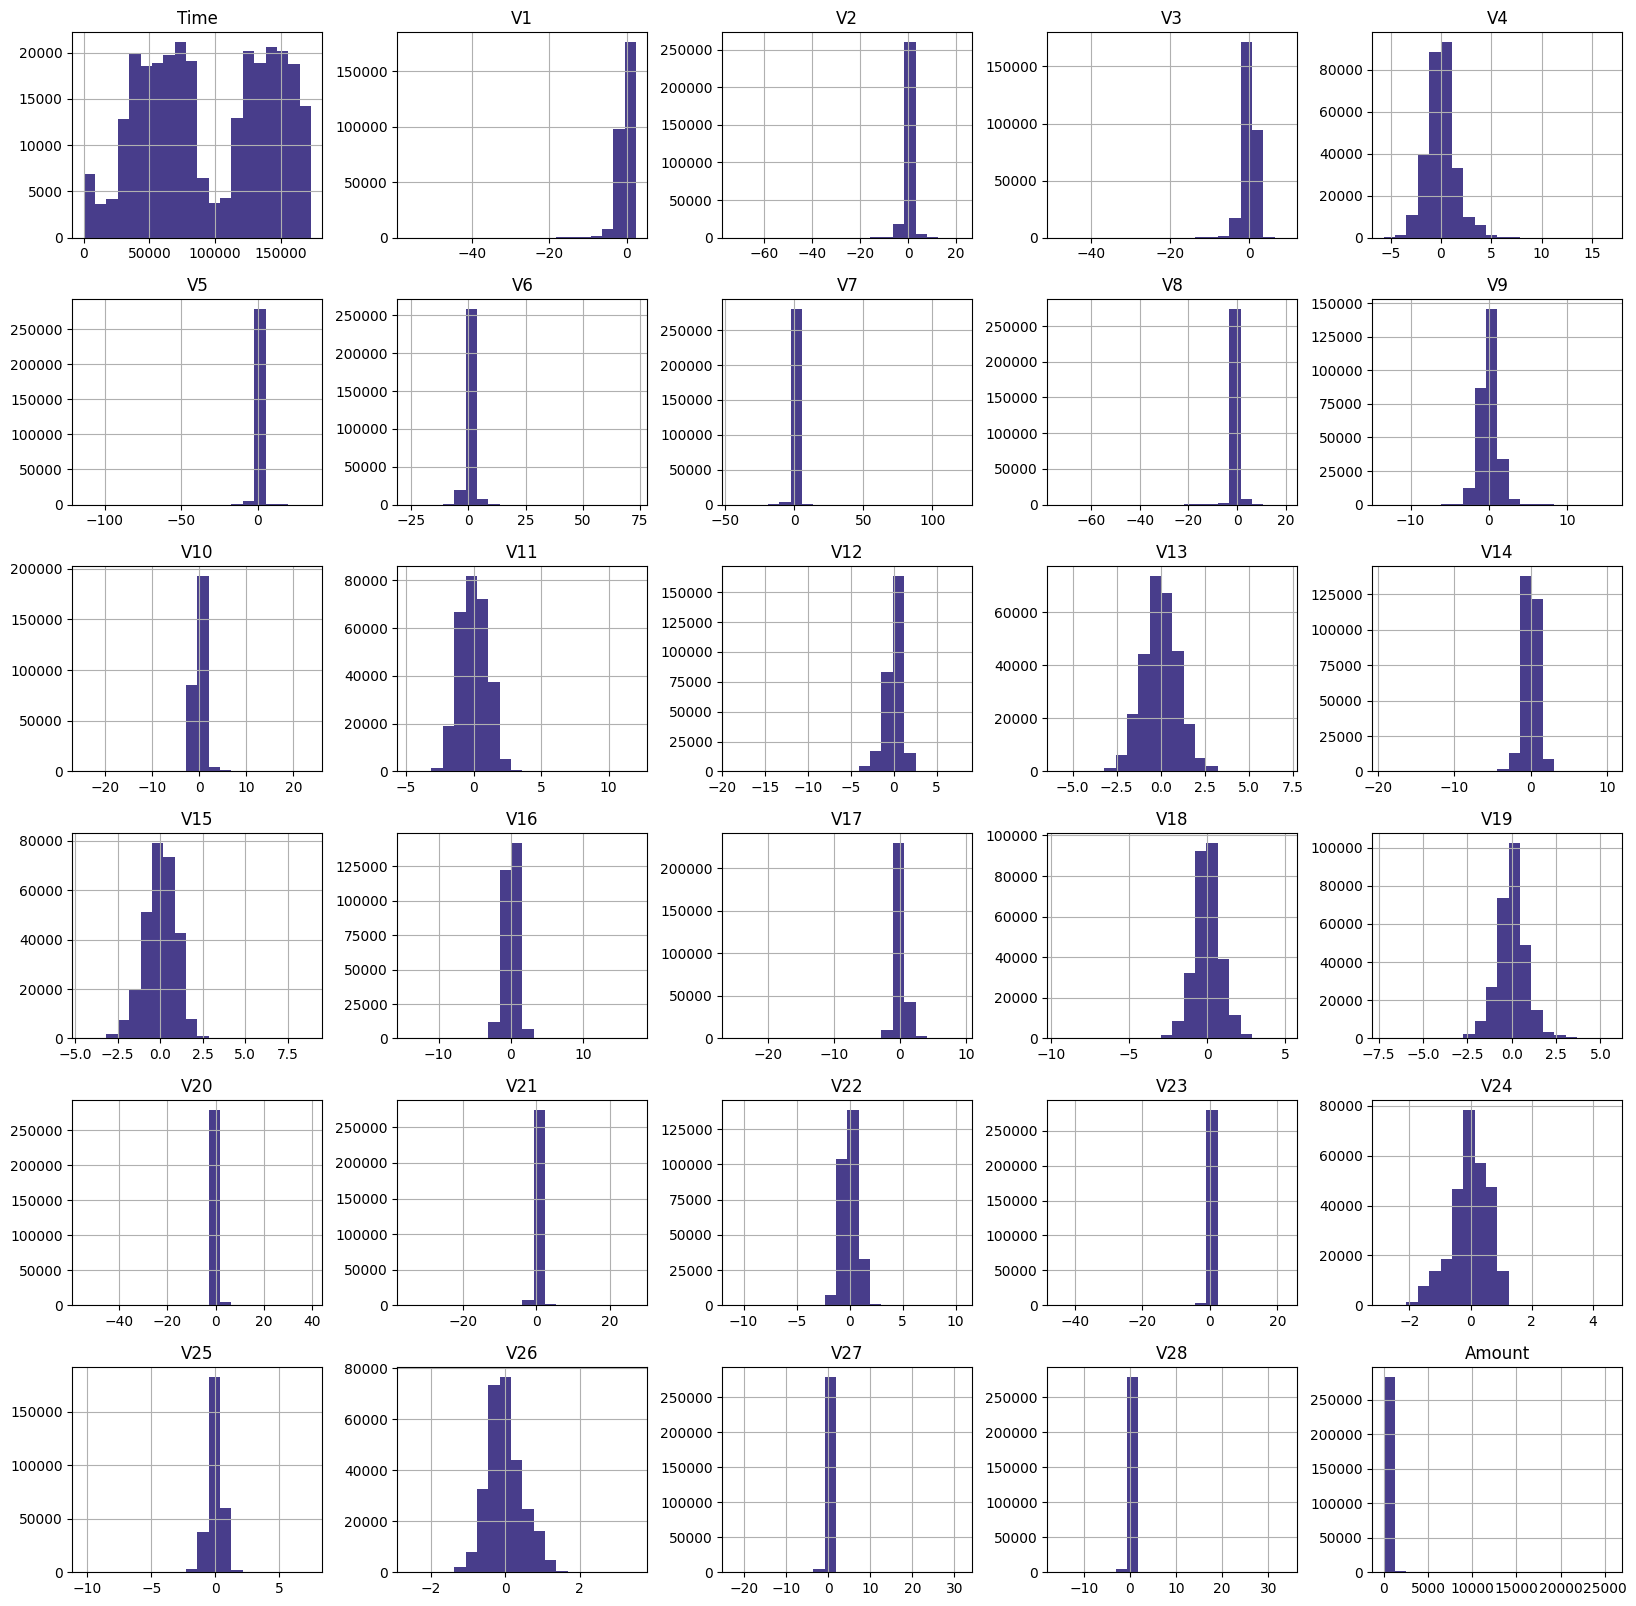

In [11]:
X.hist(figsize=(20,20),bins=20,color='#483D8B')
plt.show()

The histograms show the distribution of each feature in the dataset. Most features (V1–V28) are centered around zero and follow a roughly normal distribution, which is expected after PCA transformation. The Amount and Time features are skewed, indicating most transactions are low in value and occur in specific time periods

<Axes: xlabel='Time', ylabel='Count'>

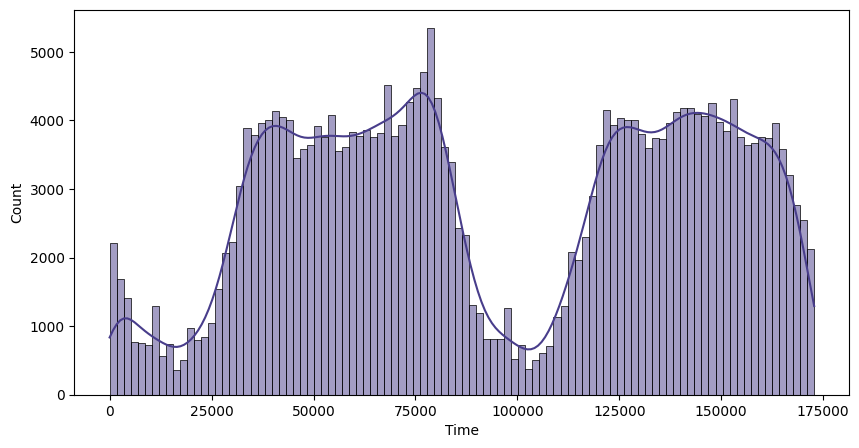

In [12]:
plt.figure(figsize=(10,5))
sns.histplot(X['Time'],kde=True,bins=100,color='#483D8B')

The distribution of Time **shows multiple peaks**, indicating that transactions occur in specific time intervals rather than uniformly throughout the day.

<Axes: xlabel='Amount', ylabel='Count'>

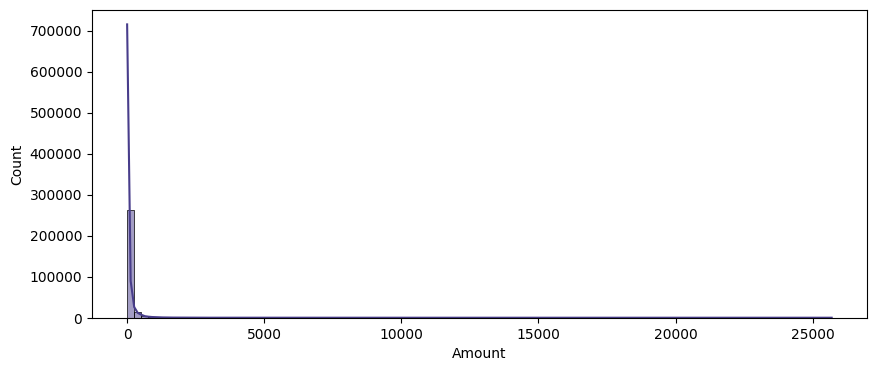

In [13]:
plt.figure(figsize=(10,4))
sns.histplot(X['Amount'],kde=True,bins=100,color='#483D8B')

The Amount distribution is **highly right-skewed**, meaning most transactions are of low value, with a few high-value outliers.

In [14]:
skewed_features = X.skew().sort_values(ascending=False)
skewed_features

Amount    16.977724
V28       11.192091
V21        3.592991
V7         2.553907
V6         1.826581
V10        1.187141
V4         0.676292
V26        0.576693
V9         0.554680
V11        0.356506
V19        0.109192
V13        0.065233
Time      -0.035568
V22       -0.213258
V18       -0.259880
V15       -0.308423
V25       -0.415793
V24       -0.552499
V16       -1.100966
V27       -1.170209
V14       -1.995176
V20       -2.037155
V3        -2.240155
V12       -2.278401
V5        -2.425901
V1        -3.280667
V17       -3.844914
V2        -4.624866
V23       -5.875140
V8        -8.521944
dtype: float64

In [15]:
Q75=X.quantile(0.75)
Q25=X.quantile(0.25)
IQR=Q75-Q25
min_point= Q25- IQR*1.5
max_point= Q75+ IQR*1.5
Outliers=((X<min_point)|(X>max_point))
print(Outliers.sum())

Time          0
V1         7062
V2        13526
V3         3363
V4        11148
V5        12295
V6        22965
V7         8948
V8        24134
V9         8283
V10        9496
V11         780
V12       15348
V13        3368
V14       14149
V15        2894
V16        8184
V17        7420
V18        7533
V19       10205
V20       27770
V21       14497
V22        1317
V23       18541
V24        4774
V25        5367
V26        5596
V27       39163
V28       30342
Amount    31904
dtype: int64


In [16]:
Outliers.sum().sum()

370372

Based on the IQR method, several features contain a large number of outliers, especially V27, V28, Amount, and V20. This is expected in fraud detection datasets, as abnormal transactions often deviate significantly from typical patterns. These outliers should not be removed blindly, as they may represent fraudulent behavior and are potentially valuable for anomaly detection models.

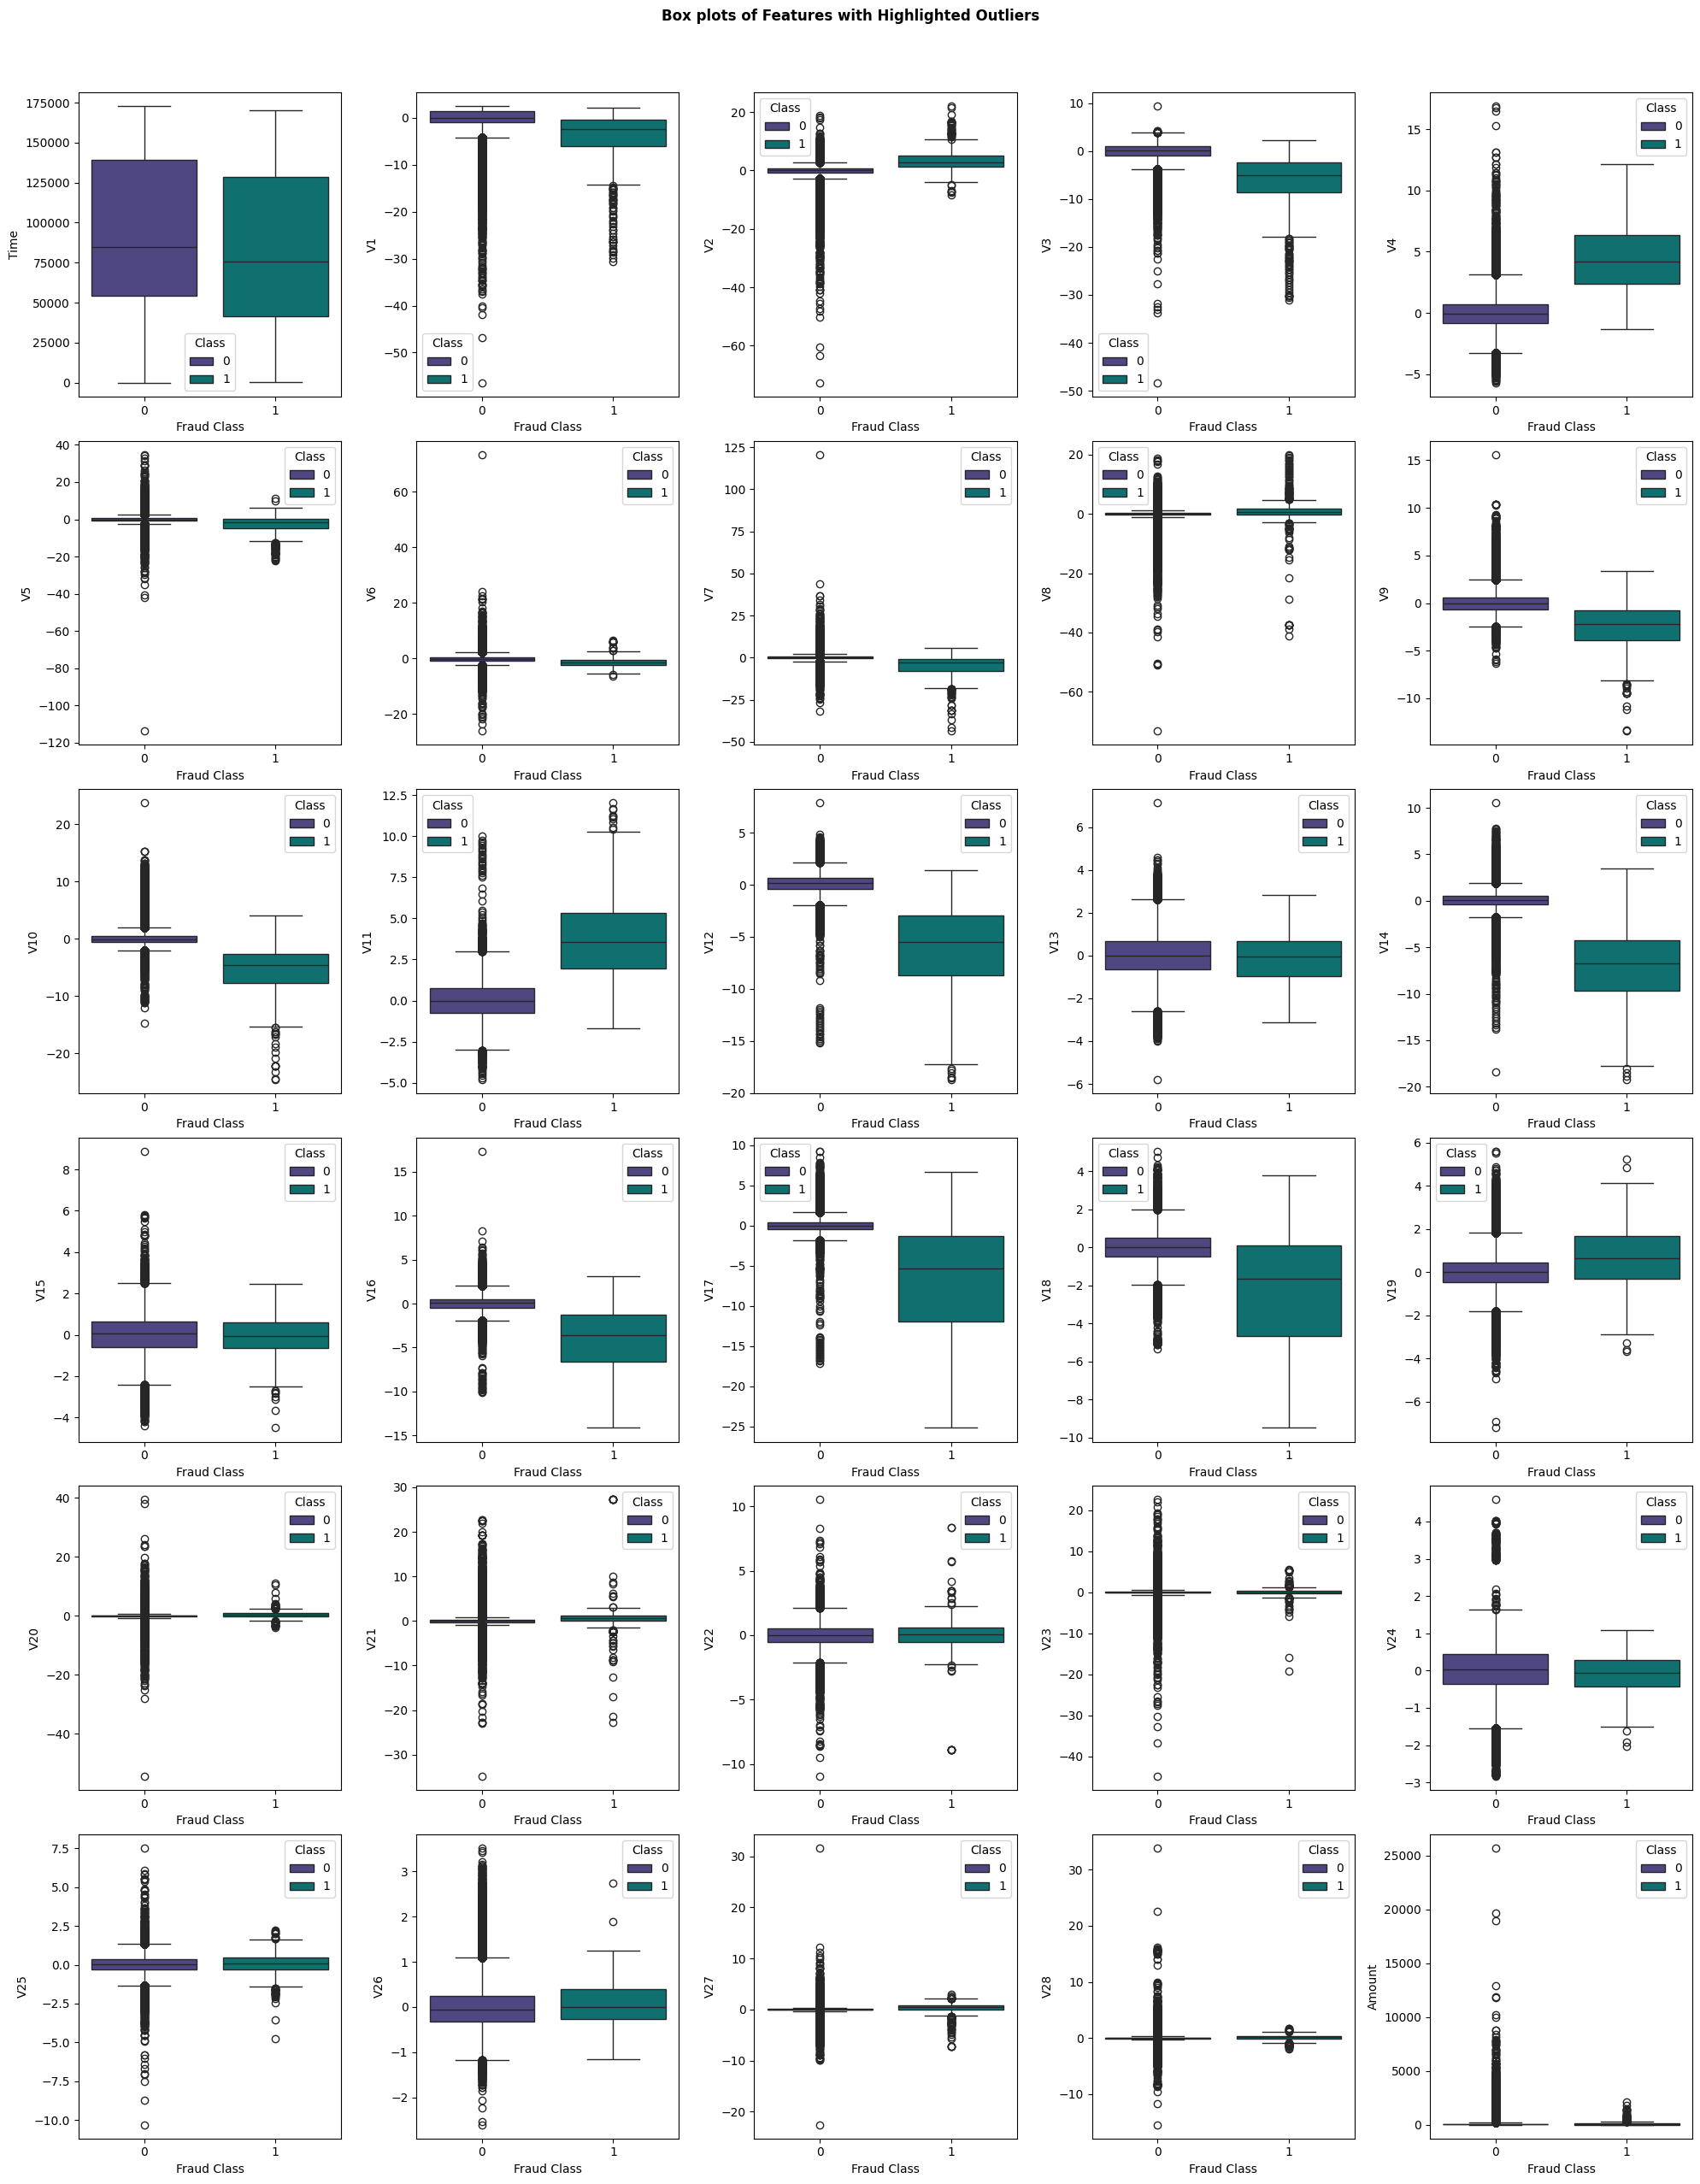

In [17]:
fig,ax=plt.subplots(6,5,figsize=(20,25))
ax=ax.flatten()

for r,c in enumerate(creditcard.columns[:-1]):
    sns.boxplot(data=creditcard,x='Class',ax=ax[r],hue='Class',y=c,palette=['#483D8B','#008080'])
    ax[r].set_xlabel('Fraud Class')


fig.suptitle('Box plots of Features with Highlighted Outliers',weight='bold',y=1.02)
fig.tight_layout(h_pad=0.3)
plt.show()

Boxplots reveal that features like (V4, V10, V12, V14, and Amount) have significant distribution differences between fraudulent and non-fraudulent transactions. Additionally, a high presence of outliers—especially in fraudulent cases—suggests that anomalies in feature values can be strong indicators of fraud.

Text(0.5, 1.0, 'Correlation Matrix')

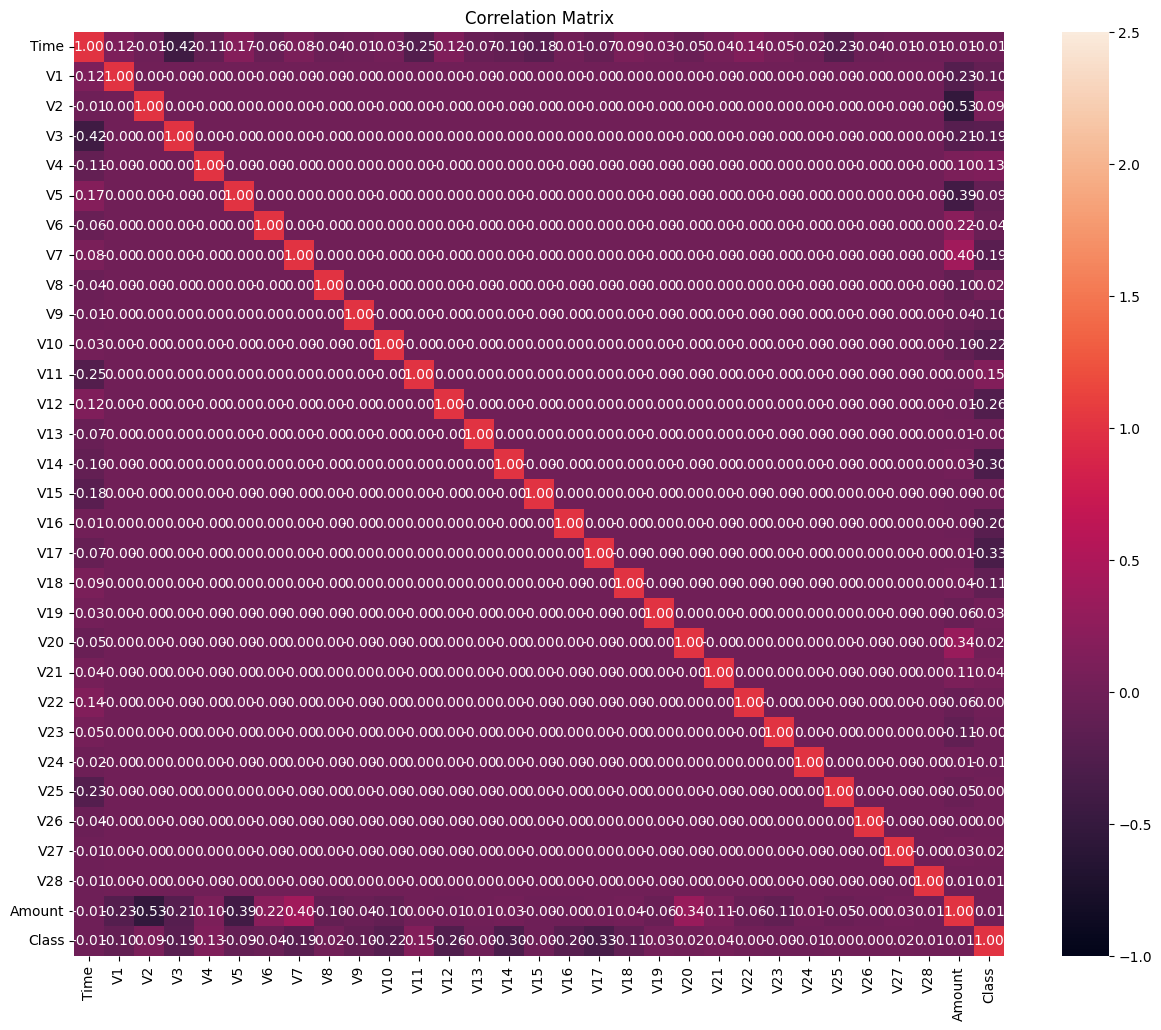

In [18]:
plt.figure(figsize=(15,12))
sns.heatmap(creditcard.corr(),annot=True,fmt=".2f", vmin=-1, vmax=2.5)
plt.title('Correlation Matrix')

In [19]:
threshold = 0.9
FeaturesCorr=X.corr().abs()
for feature in FeaturesCorr.columns:

    high_corr = FeaturesCorr[feature][(FeaturesCorr[feature] > threshold) & (FeaturesCorr[feature] < 1)].index.tolist()

high_corr

[]

Since these components are derived from PCA, it is expected that they are uncorrelated, as PCA transforms the original features into a new set of linearly uncorrelated components.

**NO**
features in the dataset have a correlation higher than 0.9 with each other.

# Class Distribution

Text(0.5, 1.0, 'Class Distribution')

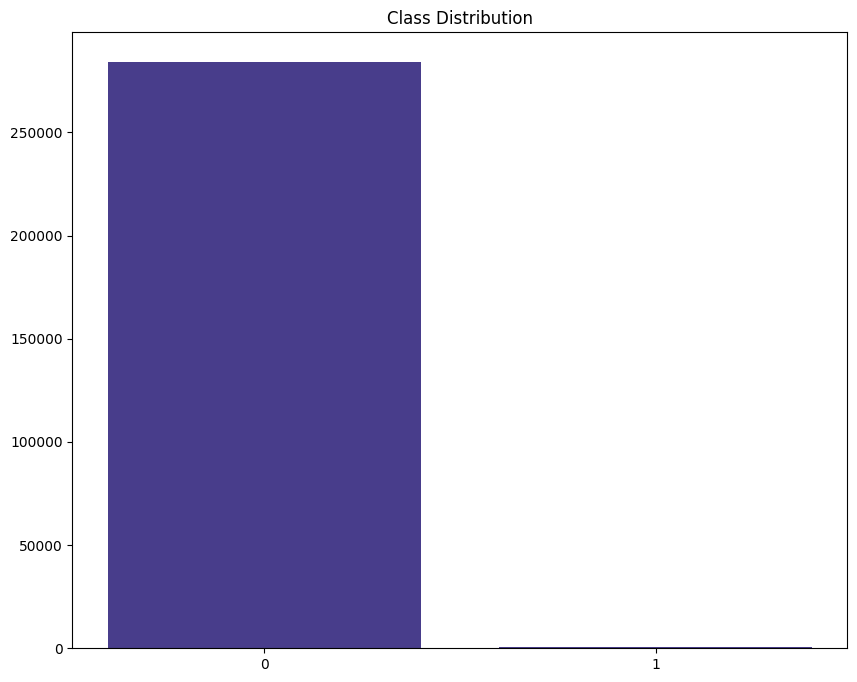

In [20]:
fig,ax=plt.subplots(figsize=(10,8))
ax.bar(y.unique(),y.value_counts(),color='#483D8B')
ax.set_xticks(y.unique())
ax.set_title('Class Distribution')

In [21]:
y.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Text(0.5, 1.0, 'Class Distribution')

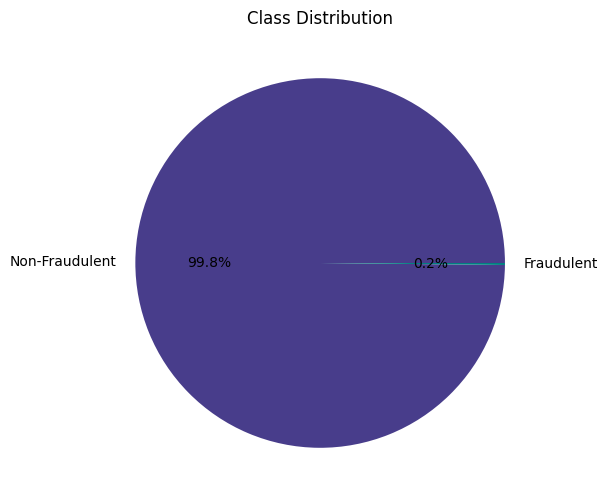

In [22]:
plt.figure(figsize=(8,6))
plt.pie(y.value_counts(),labels=['Non-Fraudulent','Fraudulent'],autopct='%1.1f%%',colors=['#483D8B','#008080'])
plt.title('Class Distribution')

The dataset **is highly imbalanced** , with approximately  **99.8%** of the transactions labeled as *non-fraudulent* and only**0.2%**as *fraudulent*. This class imbalance must be addressed before training a model to avoid biased predictions.

In [23]:
percentage = (y.value_counts() / len(y))*100
print(max(percentage)-min(percentage))

99.65450287387598


The difference between the class percentages is 99.6, highlighting a severe class imbalance in the dataset

Number of components to retain 90% variance: 27


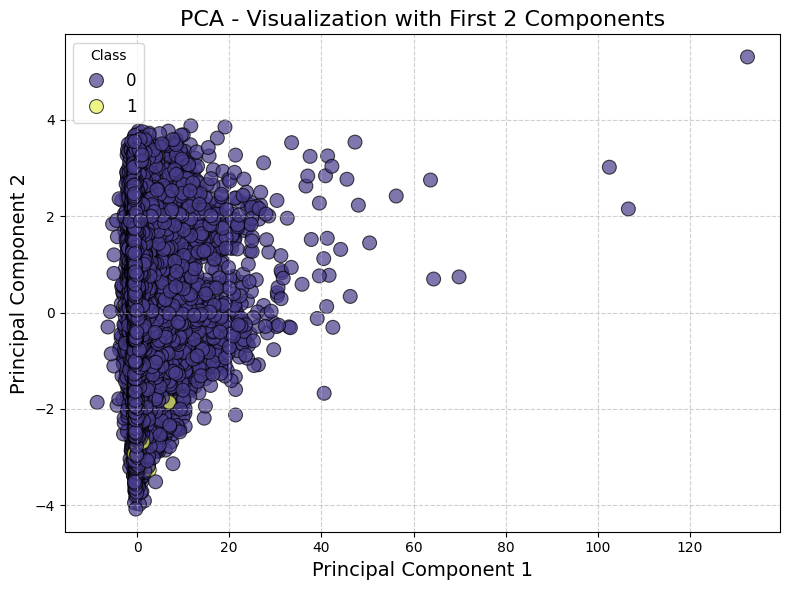

In [24]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)


pca = PCA(n_components=0.93)
X_pca = pca.fit_transform(X_scaled)
print("Number of components to retain 90% variance:" ,pca.n_components_)
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
pca_df['Label'] = y.values


plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Label', palette=['#483D8B','#E7F255'], s=100, alpha=0.7, edgecolor='k', marker='o')
plt.title('PCA - Visualization with First 2 Components', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Class', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

PCA plot showing the data in 2D using the top two principal components. Points are colored by true class labels: blue for Class 0 and orange for Class 1. The goal here is only visualization as part of EDA, not actual dimensionality reduction for modeling

The PCA visualization reveals a highly imbalanced dataset, with Class 0 overwhelmingly more frequent than Class 1. Additionally, there is no clear linear separation between the two classes in the reduced 2D space, suggesting that more complex or non-linear models may be needed for effective classification

In [25]:
'''X_sample, _ = train_test_split(X, train_size=0.04, random_state=42, stratify=y)

tsne=TSNE(n_components=2,random_state=42,perplexity=30,max_iter=500,verbose=1)
X_tsne=tsne.fit_transform(X_sample)


plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7,color='#483D8B')
plt.title(' 2D t-SNE Visualization')
ax.set_xlabel('TSNE Component 1')
ax.set_ylabel('TSNE Component 2')
plt.show()'''

"X_sample, _ = train_test_split(X, train_size=0.04, random_state=42, stratify=y)\n\ntsne=TSNE(n_components=2,random_state=42,perplexity=30,max_iter=500,verbose=1)\nX_tsne=tsne.fit_transform(X_sample)\n\n\nplt.figure(figsize=(8, 6))\nplt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7,color='#483D8B')\nplt.title(' 2D t-SNE Visualization')\nax.set_xlabel('TSNE Component 1')\nax.set_ylabel('TSNE Component 2')\nplt.show()"

# Preprocessing

Split

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
#stratify=y ensures that the split maintains the same distribution of labels as in y

Although the task is unsupervised, I split the data into training and testing sets to ensure fair evaluation of the algorithms and avoid data leakage. This allows me to fit transformations like scaling and PCA only on the training data and then apply them to the test set, simulating how the model would perform on unseen data. It is especially important when applying anomaly detection techniques like One-Class SVM and Isolation Forest, which assume the training data represents the normal behavior.

# Feature Engineering

In [27]:
#X['Hours']=(X['Time']//3600)%24

In [28]:
'''fraud_per_hour= X[y==1].groupby(X['Hours']).size()# Count fraud cases per hour
fraud_counts=fraud_per_hour.to_dict()
X['FraudCounts']=X['Hours'].map(fraud_counts).fillna(0)

for hour, count in sorted(fraud_per_hour.items()):
    print(f"Hour {hour}: {count} Fraudulent Transactions")

plt.figure(figsize=(10,6))
sns.barplot(x=X['Hours'].unique(),y=fraud_per_hour.values)
plt.title('Fraudulent Transactions per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()'''

'fraud_per_hour= X[y==1].groupby(X[\'Hours\']).size()# Count fraud cases per hour\nfraud_counts=fraud_per_hour.to_dict()\nX[\'FraudCounts\']=X[\'Hours\'].map(fraud_counts).fillna(0)\n\nfor hour, count in sorted(fraud_per_hour.items()):\n    print(f"Hour {hour}: {count} Fraudulent Transactions")\n\nplt.figure(figsize=(10,6))\nsns.barplot(x=X[\'Hours\'].unique(),y=fraud_per_hour.values)\nplt.title(\'Fraudulent Transactions per Hour\')\nplt.xlabel(\'Hour of the Day\')\nplt.ylabel(\'Number of Fraudulent Transactions\')\nplt.show()'

We initially considered adding a feature representing the number of fraud cases per hour (FraudCounts). However, since this feature would be derived using the target labels (y), it introduces the risk of data leakage. Using such a feature would allow the model to indirectly access information about the target during training, which can lead to overly optimistic results and poor generalization.
Therefore, we decided not to include this feature to maintain the integrity of the unsupervised learning process.

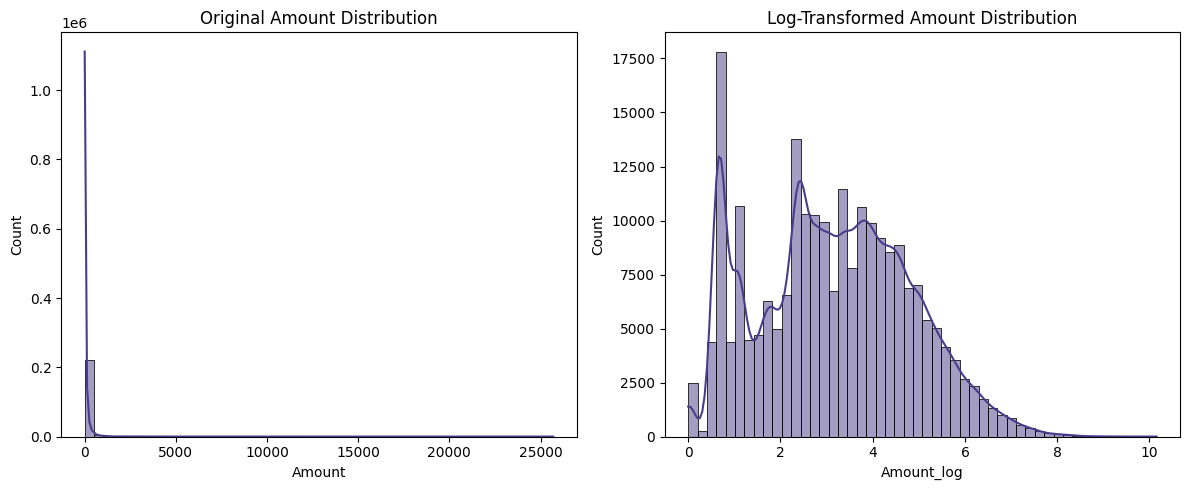

In [29]:
# Apply log transformation to the Amount column
X_train['Amount_log'] = np.log1p(X_train['Amount'])
X_test['Amount_log'] = np.log1p(X_test['Amount'])


# Plot original and transformed distributions
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(X_train['Amount'], bins=50, kde=True,color='#483D8B')
plt.title('Original Amount Distribution')

plt.subplot(1, 2, 2)
sns.histplot(X_train['Amount_log'], bins=50, kde=True,color='#483D8B')
plt.title('Log-Transformed Amount Distribution')

plt.tight_layout()
plt.show()

We applied a log1p transformation to the Amount feature to reduce right skewness and make the distribution more normal-like, which can help with model performance. Since this new feature is mathematically derived from the original, **it may cause multicollinearity**. We will later check for multicollinearity before deciding whether to drop the original Amount feature.



In [30]:
X_train[['Amount','Amount_log']].corr()

Amount  Amount_log
Amount      1.000000    0.548568
Amount_log  0.548568    1.000000

We created a log-transformed version of the Amount feature (Amount_log) to reduce skewness. After evaluating both features in a separate notebook — including clustering metrics and anomaly detection performance — we found that the results were nearly identical.
Additionally, a correlation check showed no strong multicollinearity between Amount and Amount_log.
Therefore, we decided to keep only one to avoid redundancy, while noting that using either will not negatively affect model performance.

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


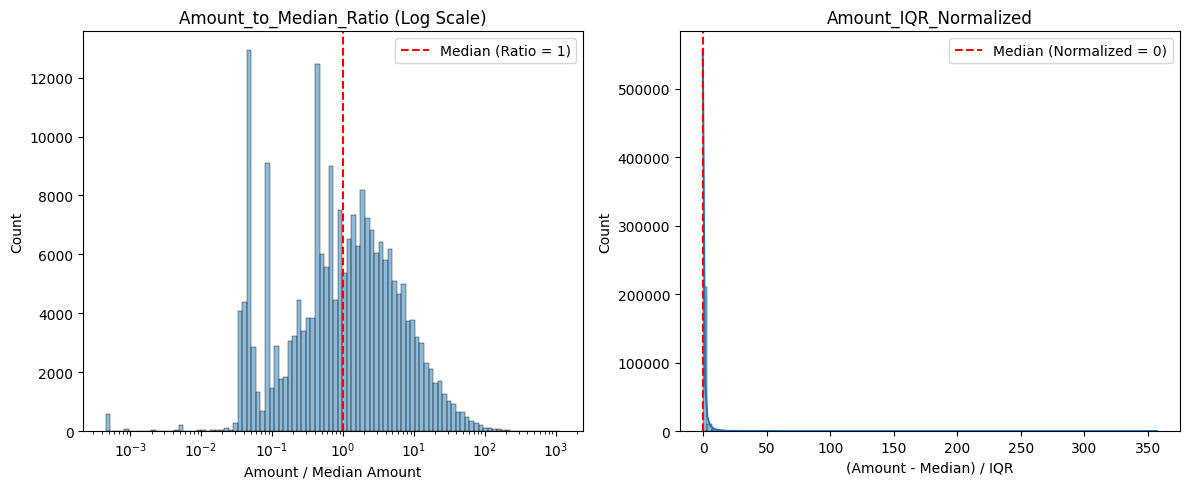

In [31]:
# Compute median and IQR for 'Amount'
median_amount = X_train['Amount'].median()
iqr = X_train['Amount'].quantile(0.75) - X_train['Amount'].quantile(0.25)

# Add new features to X
X_train['Amount_to_Median_Ratio'] = X_train['Amount'] / (median_amount + 1e-6)  # Avoid division by zero
X_test['Amount_to_Median_Ratio'] = X_test['Amount'] / (median_amount + 1e-6)


X_train['Amount_IQR_Normalized'] = (X_train['Amount'] - median_amount) / (iqr + 1e-6)
X_test['Amount_IQR_Normalized'] = (X_test['Amount'] - median_amount) / (iqr + 1e-6)


plt.figure(figsize=(12, 5))

# Plot 1: Amount_to_Median_Ratio
plt.subplot(1, 2, 1)
sns.histplot(X_train['Amount_to_Median_Ratio'], bins=100, kde=True, log_scale=True)
plt.axvline(x=1, color='red', linestyle='--', label='Median (Ratio = 1)')
plt.title('Amount_to_Median_Ratio (Log Scale)')
plt.xlabel('Amount / Median Amount')
plt.legend()

# Plot 2: Amount_IQR_Normalized
plt.subplot(1, 2, 2)
sns.histplot(X_train['Amount_IQR_Normalized'], bins=100, kde=True)
plt.axvline(x=0, color='red', linestyle='--', label='Median (Normalized = 0)')
plt.title('Amount_IQR_Normalized')
plt.xlabel('(Amount - Median) / IQR')
plt.legend()

plt.tight_layout()
plt.show()

1. Amount_to_Median_Ratio

Why This Feature?

Captures Relative Scale:

Fraudulent transactions often deviate significantly from typical spending amounts.

Dividing by the median (instead of mean) makes the feature robust to outliers.

Unsupervised-Friendly:

Does not require labeled fraud data.

Highlights transactions that are abnormally large or small compared to the median.

Interpretation:

Ratio ≈ 1: Transaction is close to the median (normal behavior).

Ratio ≫ 1: Unusually large transaction (potential fraud).

Ratio ≪ 1: Unusually small transaction (may indicate test transactions or errors).

Example:

If the median transaction is $50, a $500 transaction has a ratio of 10, flagging it as anomalous.



2. Amount_IQR_Normalized

Why This Feature?

Standardizes Deviations:

Measures how far a transaction is from the median, scaled by the IQR (a robust measure of spread).

Better than Z-score (which uses mean/std) because it’s resistant to outliers.

Anomaly Detection:

Values beyond ±3 are statistically rare (3×IQR rule).

Fraud often falls in these extremes.

Interpretation:

Value ≈ 0: Transaction is near the median (normal).

Value > +3: Extremely high amount (possible fraud).

Value < -3: Extremely low amount (may be suspicious).


# Fix skewness

In [32]:
X_train_skewed_features = X_train.skew().sort_values(ascending=False)

In [33]:
skewed_features2=X_train_skewed_features[abs(X_train_skewed_features.values)>0.75]
print(skewed_features2)
skewed_features2=skewed_features2.index

Amount                    18.193943
Amount_IQR_Normalized     18.193943
Amount_to_Median_Ratio    18.193943
V28                        9.978409
V21                        3.490183
V7                         3.152665
V6                         1.937381
V10                        1.132688
V27                       -0.890209
V16                       -1.077909
V20                       -1.960492
V14                       -1.969112
V3                        -2.247962
V12                       -2.286654
V5                        -2.786851
V1                        -3.306334
V17                       -3.733377
V2                        -4.779484
V23                       -6.258558
V8                        -8.639485
dtype: float64


In [34]:
yj=PowerTransformer(method='yeo-johnson')

X_train[skewed_features2] =yj.fit_transform(X_train[skewed_features2])

In [35]:
after_fixed=X_train.skew().sort_values(ascending=False)
after_fixed

V27                       3.731696
V7                        2.883669
V8                        2.382707
V28                       1.320689
V4                        0.687574
V26                       0.574980
V9                        0.541869
Amount_IQR_Normalized     0.417497
V11                       0.354102
V2                        0.336876
Amount_to_Median_Ratio    0.253813
V12                       0.162452
Amount_log                0.160393
V16                       0.156780
V19                       0.106133
V14                       0.101347
V13                       0.064819
Amount                    0.018154
Time                     -0.037394
V3                       -0.079701
V1                       -0.218136
V22                      -0.219171
V18                      -0.254948
V23                      -0.255033
V15                      -0.308419
V25                      -0.436292
V24                      -0.549854
V17                      -0.805442
V20                      -0.879795
V10                      -1.329089
V5                       -1.349420
V6                       -2.001738
V21                      -2.076985
dtype: float64

In [36]:
new_skewed_features=after_fixed[abs(after_fixed.values)>0.75].index
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_train[new_skewed_features] =qt.fit_transform(X_train[new_skewed_features])

#just apply the transform on the X_test
X_test[new_skewed_features] =qt.transform(X_test[new_skewed_features])

In [37]:
X_train.skew().sort_values(ascending=False)

V4                        0.687574
V26                       0.574980
V9                        0.541869
Amount_IQR_Normalized     0.417497
V11                       0.354102
V2                        0.336876
Amount_to_Median_Ratio    0.253813
V12                       0.162452
Amount_log                0.160393
V16                       0.156780
V19                       0.106133
V14                       0.101347
V13                       0.064819
V8                        0.028243
Amount                    0.018154
V28                       0.013845
V7                        0.008920
V27                      -0.009439
V10                      -0.011131
V6                       -0.011925
V20                      -0.024530
V21                      -0.030122
V17                      -0.032147
Time                     -0.037394
V5                       -0.056541
V3                       -0.079701
V1                       -0.218136
V22                      -0.219171
V18                      -0.254948
V23                      -0.255033
V15                      -0.308419
V25                      -0.436292
V24                      -0.549854
dtype: float64

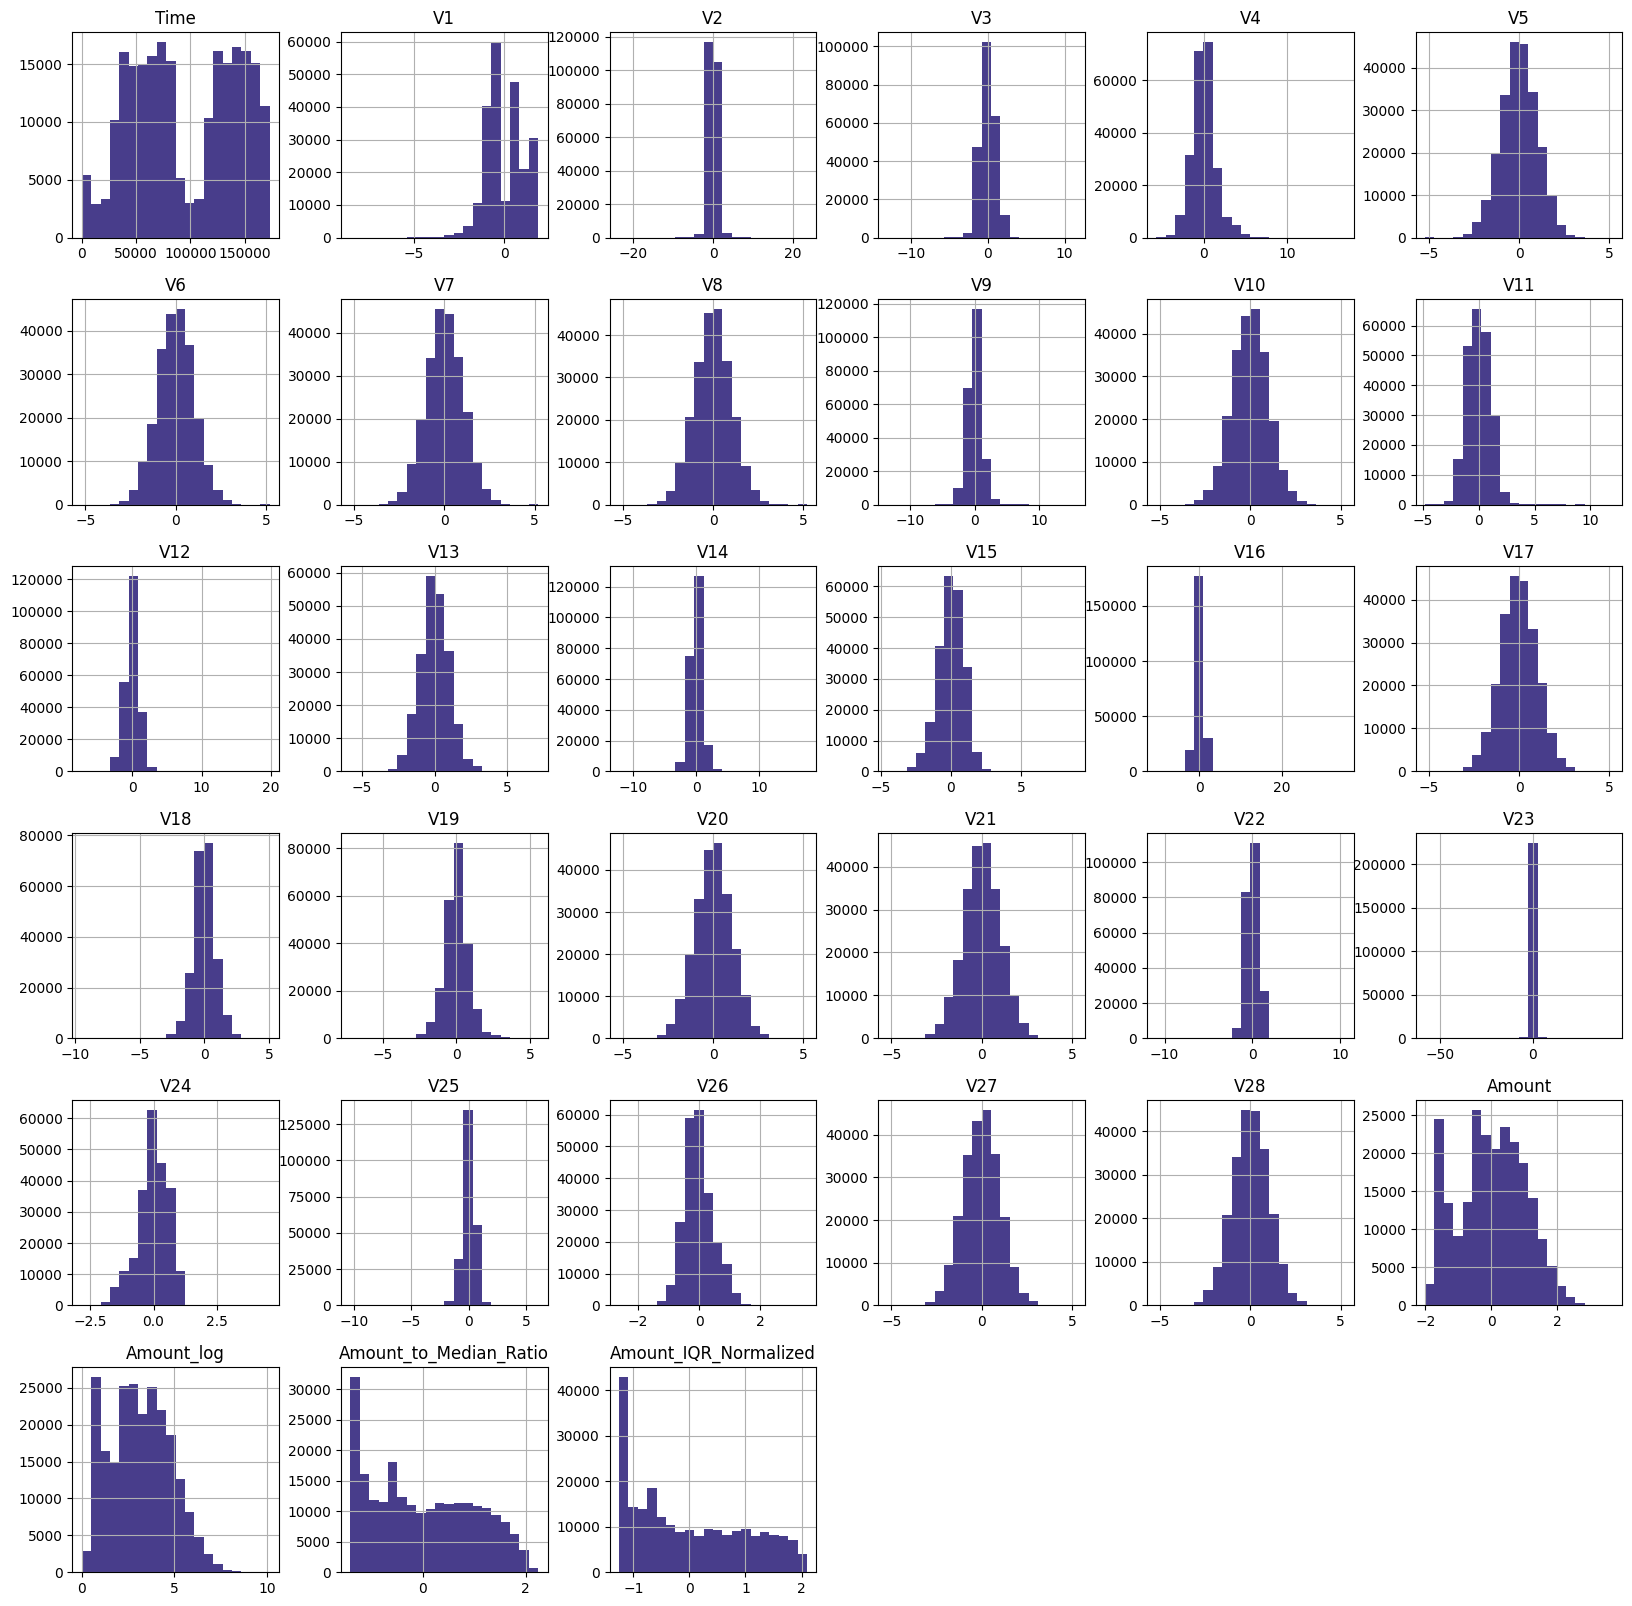

In [38]:
X_train.hist(figsize=(20,20),bins=20,color='#483D8B')
plt.show()

Initially, the dataset showed significant skewness in several features, especially Amount and some PCA components. To address this, **the Yeo-Johnson** transformation was applied, as it can handle both positive and negative values unlike log-transformations.

While this reduced skewness for many features, *some variables remained
non-Gaussian and showed heavy tails* . Therefore, a **Quantile Transformer** was
subsequently applied to map the data to a uniform distribution and then approximate a normal distribution.

This two-step transformation significantly improved feature distributions, making them more suitable for clustering and anomaly detection models.

# Scaling

In [39]:
scaler=StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA

In [40]:
pca=PCA().fit(X_train_scaled)

In [41]:
eigenvalues=pca.explained_variance_
eigenvalues

array([4.51129810e+00, 2.13957903e+00, 1.85817085e+00, 1.65474737e+00,
       1.43409011e+00, 1.35974334e+00, 1.29744424e+00, 1.25682797e+00,
       1.16868271e+00, 1.15398952e+00, 1.08173478e+00, 1.06354315e+00,
       1.02280493e+00, 1.00917174e+00, 1.00124589e+00, 9.98926810e-01,
       9.90539541e-01, 9.69086583e-01, 9.47330485e-01, 9.44973057e-01,
       9.05700965e-01, 8.03341595e-01, 5.82782888e-01, 5.35256152e-01,
       4.88679513e-01, 4.42096293e-01, 3.86703797e-01, 3.37729522e-01,
       3.28884250e-01, 2.88571871e-01, 3.58302844e-02, 5.43009526e-04,
       9.44719875e-05])

pca.explained_variance_ returns the **eigenvalues** corresponding to each principal component. These values represent the **amount of variance** captured by each component in the transformed feature space.

This means:
- The **first principal component** captures 2.65 units of variance from the original data.
- The **second principal component** captures 2.16 units.
- The **third principal component** captures 1.85 units, and so on.

Larger eigenvalues indicate that the component explains more variability in the data. PCA arranges components in decreasing order of these values, so the first components are the most informative. These eigenvalues are also used to compute the explained variance ratio, which helps in selecting the number of components to retain.




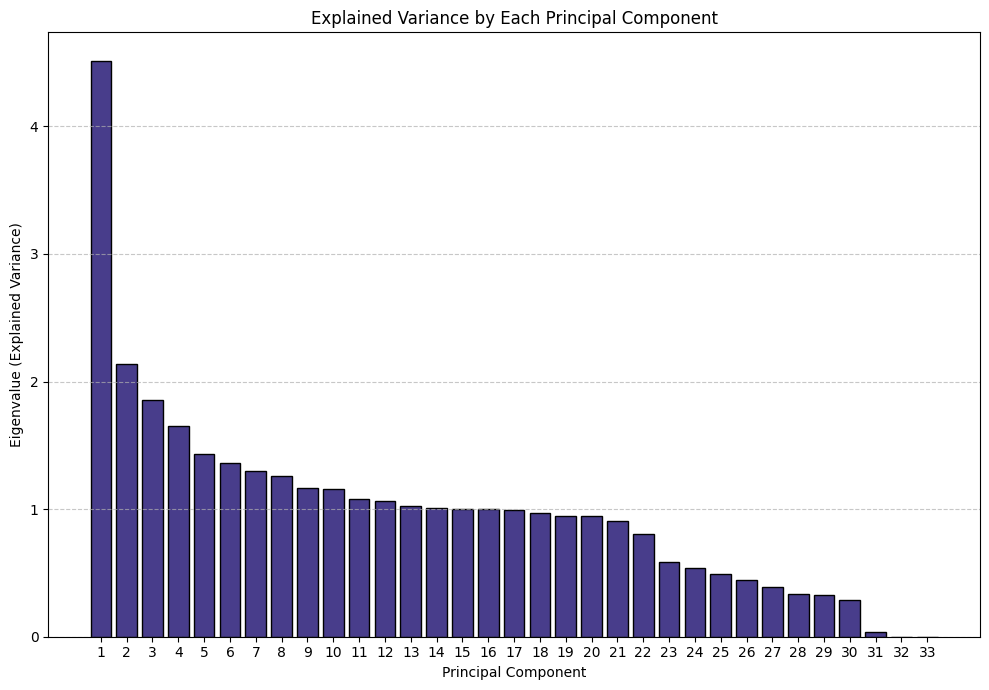

In [42]:
components = np.arange(1, len(eigenvalues) + 1)

plt.figure(figsize=(10, 7))
plt.bar(components, eigenvalues, color='#483D8B', edgecolor='black')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.title('Explained Variance by Each Principal Component')
plt.xticks(components)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [43]:
cumulativeVariance=np.cumsum(pca.explained_variance_ratio_)#This line calculates the cumulative sum of the variance explained by each principal component in PCA
cumulativeVariance

array([0.1367054 , 0.20154085, 0.25784881, 0.30799245, 0.35144953,
       0.39265369, 0.43197001, 0.47005554, 0.50547002, 0.54043924,
       0.57321894, 0.60544738, 0.63644133, 0.66702216, 0.69736281,
       0.72763319, 0.7576494 , 0.78701554, 0.81572239, 0.84435782,
       0.87180318, 0.89614676, 0.91380677, 0.93002658, 0.94483498,
       0.95823178, 0.96995003, 0.98018421, 0.99015036, 0.99889492,
       0.99998068, 0.99999714, 1.        ])

The goal is to calculate the total variance explained by the first n principal components, helping decide how many components are needed to capture a desired percentage of the total variance.

In [44]:
n_components=np.argmax(cumulativeVariance>=0.93)+1 #Determines the number of principal components needed to retain at least 93% of the cumulative variance in PCA
print('The number of principal component is:' ,n_components)

The number of principal component is: 24


The number of principal components was set to 25, based on the analysis of the explained variance ratio, where it was observed that the first 25 components account for a significant portion of the total variance in the data. Additionally, the eigenvalues of these components were relatively high compared to the subsequent components, supporting the selection of this number as a sufficiently representative set without losing important information.

In [45]:
plt.figure(figsize=(10,6))
fig = go.Figure()
#cumulative variance plot
fig.add_trace(go.Scatter(x=list(range(1, len(cumulativeVariance) + 1)),
                         y=cumulativeVariance,
                         mode='markers+lines',
                         name='Cumulative Variance',
                         marker=dict(color='#483D8B')
                        ))

# Add the 95% threshold line
fig.add_trace(go.Scatter(x=[1, len(cumulativeVariance)],
                         y=[0.93, 0.93],
                         mode='lines',
                         name='93% Threshold',
                         line=dict(dash='dash'),
                         marker=dict(color='#E7F255')
                        ))


fig.update_layout(
    title="Cumulative Variance vs Number of Principal Components",
    xaxis_title="Number of Principal Components",
    yaxis_title="Cumulative Variance Percentage",
    template="plotly_dark",
    showlegend=True
)

fig.show()


<Figure size 1000x600 with 0 Axes>

In [46]:
print(X_train_scaled.shape)

(227845, 33)


In [47]:
pca2=PCA(n_components=n_components)
X_train_pca=pca2.fit_transform(X_train_scaled)
X_test_pca=pca2.transform(X_test_scaled)

In [48]:
print(X_train_pca.shape)

(227845, 24)


After applying PCA, the number of principal components was reduced while retaining 93% of the cumulative variance, resulting in a more efficient representation of the data with fewer dimensions

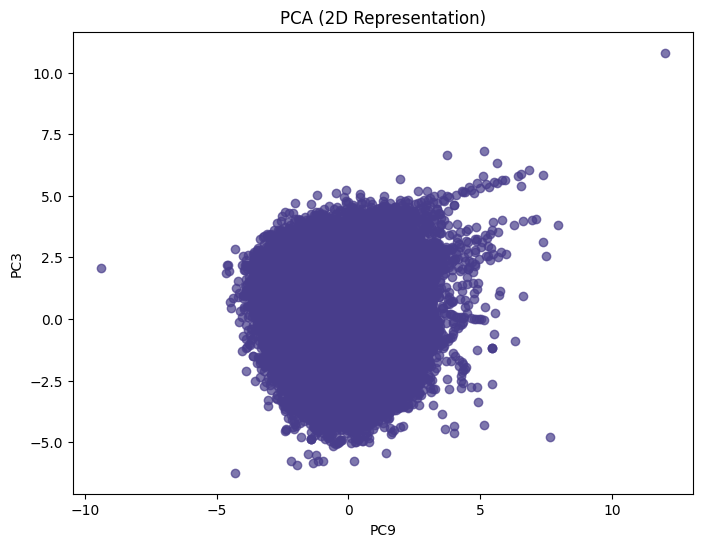

In [49]:
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,9], X_train_pca[:,3], alpha=0.7,color='#483D8B')# the components are chosen randomly
plt.title('PCA (2D Representation)')
plt.xlabel('PC9')
plt.ylabel('PC3')
plt.show()

# SMOTE ALGO

What is SMOTE?  

SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to address class imbalance by creating synthetic examples of the minority class instead of just duplicating them.

We use the Smote algo because our dataset is highly imbalanced cause most models to be biased toward the majority class(Non-Fraudulent).

The requirements for this algo :

1-) Labeled classification task:Must have imbalanced labels (with y_train showing minority and majority classes).

2-)

In [50]:
y_train.value_counts()

Class
0    227451
1       394
Name: count, dtype: int64

In [51]:
print("Before SMOTE:", Counter(y_train))

#Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_pca, y_train)

# Check new class distribution
print("After SMOTE:", Counter(y_train_res))

Before SMOTE: Counter({0: 227451, 1: 394})
After SMOTE: Counter({0: 227451, 1: 227451})


Text(0.5, 1.0, 'Class Distribution')

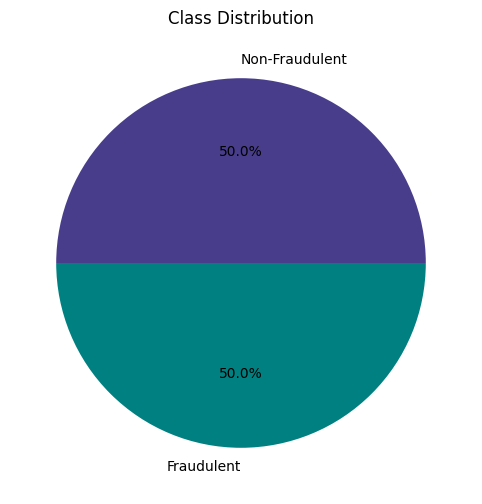

In [52]:
plt.figure(figsize=(8,6))
plt.pie(y_train_res.value_counts(),labels=['Non-Fraudulent','Fraudulent'],autopct='%1.1f%%',colors=['#483D8B','#008080'])
plt.title('Class Distribution')

In [53]:
'''strategies = [0.4,0.5,0.6,0.7,0.8,'auto']




for strategy in strategies:
    print(f"\n===== Sampling Strategy: {strategy} =====")


    smote = SMOTE(sampling_strategy=strategy, random_state=42, k_neighbors=7)
    X_res, y_res = smote.fit_resample(X_train_scaled, y_train)


    clf = LogisticRegression(random_state=42)
    clf.fit(X_res, y_res)


    y_pred = clf.predict(X_test_scaled)

    print(classification_report(y_test, y_pred, digits=4))

    #--------------------------------------------------------------------
# We want to define values for the k_neighbors hyperparameter and sampling_strategy
strategies = [0.4, 0.5, 0.6, 0.7, 0.8, 'auto']
k_values = [3, 5, 7, 9]

for k in k_values:
    print(f"\n======================")
    print(f"Testing k_neighbors = {k}")

    for strategy in strategies:
        print(f"\n--- Sampling Strategy: {strategy} ---")

        # Apply SMOTE with current k and strategy
        smote = SMOTE(sampling_strategy=strategy, random_state=42, k_neighbors=k)
        X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

        print("Resampled Class Distribution:", Counter(y_res))

        # Train Logistic Regression
        clf = RandomForestClassifier(n_estimators=30,max_depth=10,random_state=42, n_jobs=-1)
        clf.fit(X_res, y_res)

        # Predict and evaluate
        y_pred = clf.predict(X_test_scaled)
        print(classification_report(y_test, y_pred, digits=4))'''

'strategies = [0.4,0.5,0.6,0.7,0.8,\'auto\']\n\n\n\n\nfor strategy in strategies:\n    print(f"\n===== Sampling Strategy: {strategy} =====")\n\n\n    smote = SMOTE(sampling_strategy=strategy, random_state=42, k_neighbors=7)\n    X_res, y_res = smote.fit_resample(X_train_scaled, y_train)\n\n\n    clf = LogisticRegression(random_state=42)\n    clf.fit(X_res, y_res)\n\n\n    y_pred = clf.predict(X_test_scaled)\n\n    print(classification_report(y_test, y_pred, digits=4))\n\n    #--------------------------------------------------------------------\n# We want to define values for the k_neighbors hyperparameter and sampling_strategy\nstrategies = [0.4, 0.5, 0.6, 0.7, 0.8, \'auto\']\nk_values = [3, 5, 7, 9]\n\nfor k in k_values:\n    print(f"\n======================")\n    print(f"Testing k_neighbors = {k}")\n\n    for strategy in strategies:\n        print(f"\n--- Sampling Strategy: {strategy} ---")\n\n        # Apply SMOTE with current k and strategy\n        smote = SMOTE(sampling_strategy

======================
Testing k_neighbors = 3

--- Sampling Strategy: 0.4 ---
Resampled Class Distribution: Counter({0: 227451, 1: 90980})
              precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     56864
           1     0.7297    0.8265    0.7751        98

    accuracy                         0.9992     56962
   macro avg     0.8647    0.9130    0.8874     56962
weighted avg     0.9992    0.9992    0.9992     56962


--- Sampling Strategy: 0.5 ---
Resampled Class Distribution: Counter({0: 227451, 1: 113725})
              precision    recall  f1-score   support

           0     0.9996    0.9996    0.9996     56864
           1     0.7723    0.7959    0.7839        98

    accuracy                         0.9992     56962
   macro avg     0.8860    0.8978    0.8918     56962
weighted avg     0.9993    0.9992    0.9993     56962


--- Sampling Strategy: 0.6 ---
Resampled Class Distribution: Counter({0: 227451, 1: 136470})
              precision    recall  f1-score   support

           0     0.9996    0.9995    0.9996     56864
           1     0.7222    0.7959    0.7573        98

    accuracy                         0.9991     56962
   macro avg     0.8609    0.8977    0.8784     56962
weighted avg     0.9992    0.9991    0.9991     56962


--- Sampling Strategy: 0.7 ---
Resampled Class Distribution: Counter({0: 227451, 1: 159215})
              precision    recall  f1-score   support

           0     0.9997    0.9991    0.9994     56864
           1     0.6172    0.8061    0.6991        98

    accuracy                         0.9988     56962
   macro avg     0.8084    0.9026    0.8493     56962
weighted avg     0.9990    0.9988    0.9989     56962


--- Sampling Strategy: 0.8 ---
Resampled Class Distribution: Counter({0: 227451, 1: 181960})
              precision    recall  f1-score   support

           0     0.9998    0.9990    0.9994     56864
           1     0.6000    0.8571    0.7059        98

    accuracy                         0.9988     56962
   macro avg     0.7999    0.9281    0.8526     56962
weighted avg     0.9991    0.9988    0.9989     56962


--- Sampling Strategy: auto ---
Resampled Class Distribution: Counter({0: 227451, 1: 227451})
              precision    recall  f1-score   support

           0     0.9997    0.9988    0.9993     56864
           1     0.5503    0.8367    0.6640        98

    accuracy                         0.9985     56962
   macro avg     0.7750    0.9178    0.8316     56962
weighted avg     0.9989    0.9985    0.9987     56962


======================
Testing k_neighbors = 5

--- Sampling Strategy: 0.4 ---
Resampled Class Distribution: Counter({0: 227451, 1: 90980})
              precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     56864
           1     0.7593    0.8367    0.7961        98

    accuracy                         0.9993     56962
   macro avg     0.8795    0.9181    0.8979     56962
weighted avg     0.9993    0.9993    0.9993     56962


--- Sampling Strategy: 0.5 ---
Resampled Class Distribution: Counter({0: 227451, 1: 113725})
              precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     56864
           1     0.7431    0.8265    0.7826        98

    accuracy                         0.9992     56962
   macro avg     0.8714    0.9130    0.8911     56962
weighted avg     0.9993    0.9992    0.9992     56962


--- Sampling Strategy: 0.6 ---
Resampled Class Distribution: Counter({0: 227451, 1: 136470})
              precision    recall  f1-score   support

           0     0.9997    0.9991    0.9994     56864
           1     0.6241    0.8469    0.7186        98

    accuracy                         0.9989     56962
   macro avg     0.8119    0.9230    0.8590     56962
weighted avg     0.9991    0.9989    0.9989     56962


--- Sampling Strategy: 0.7 ---
Resampled Class Distribution: Counter({0: 227451, 1: 159215})
              precision    recall  f1-score   support

           0     0.9997    0.9990    0.9994     56864
           1     0.5929    0.8469    0.6975        98

    accuracy                         0.9987     56962
   macro avg     0.7963    0.9230    0.8484     56962
weighted avg     0.9990    0.9987    0.9988     56962


--- Sampling Strategy: 0.8 ---
Resampled Class Distribution: Counter({0: 227451, 1: 181960})
              precision    recall  f1-score   support

           0     0.9997    0.9989    0.9993     56864
           1     0.5608    0.8469    0.6748        98

    accuracy                         0.9986     56962
   macro avg     0.7803    0.9229    0.8370     56962
weighted avg     0.9990    0.9986    0.9987     56962


--- Sampling Strategy: auto ---
Resampled Class Distribution: Counter({0: 227451, 1: 227451})
              precision    recall  f1-score   support

           0     0.9997    0.9983    0.9990     56864
           1     0.4551    0.8265    0.5870        98

    accuracy                         0.9980     56962
   macro avg     0.7274    0.9124    0.7930     56962
weighted avg     0.9988    0.9980    0.9983     56962


======================
Testing k_neighbors = 7

--- Sampling Strategy: 0.4 ---
Resampled Class Distribution: Counter({0: 227451, 1: 90980})
              precision    recall  f1-score   support

           0     0.9997    0.9993    0.9995     56864
           1     0.6780    0.8163    0.7407        98

    accuracy                         0.9990     56962
   macro avg     0.8388    0.9078    0.8701     56962
weighted avg     0.9991    0.9990    0.9991     56962


--- Sampling Strategy: 0.5 ---
Resampled Class Distribution: Counter({0: 227451, 1: 113725})
              precision    recall  f1-score   support

           0     0.9995    0.9994    0.9994     56864
           1     0.6604    0.7143    0.6863        98

    accuracy                         0.9989     56962
   macro avg     0.8299    0.8568    0.8429     56962
weighted avg     0.9989    0.9989    0.9989     56962


--- Sampling Strategy: 0.6 ---
Resampled Class Distribution: Counter({0: 227451, 1: 136470})
              precision    recall  f1-score   support

           0     0.9995    0.9990    0.9992     56864
           1     0.5397    0.6939    0.6071        98

    accuracy                         0.9985     56962
   macro avg     0.7696    0.8464    0.8032     56962
weighted avg     0.9987    0.9985    0.9986     56962


--- Sampling Strategy: 0.7 ---
Resampled Class Distribution: Counter({0: 227451, 1: 159215})
              precision    recall  f1-score   support

           0     0.9997    0.9988    0.9992     56864
           1     0.5359    0.8367    0.6534        98

    accuracy                         0.9985     56962
   macro avg     0.7678    0.9177    0.8263     56962
weighted avg     0.9989    0.9985    0.9986     56962


--- Sampling Strategy: 0.8 ---
Resampled Class Distribution: Counter({0: 227451, 1: 181960})
              precision    recall  f1-score   support

           0     0.9995    0.9983    0.9989     56864
           1     0.4176    0.7245    0.5299        98

    accuracy                         0.9978     56962
   macro avg     0.7086    0.8614    0.7644     56962
weighted avg     0.9985    0.9978    0.9981     56962


--- Sampling Strategy: auto ---
Resampled Class Distribution: Counter({0: 227451, 1: 227451})
              precision    recall  f1-score   support

           0     0.9997    0.9977    0.9987     56864
           1     0.3857    0.8265    0.5260        98

    accuracy                         0.9974     56962
   macro avg     0.6927    0.9121    0.7623     56962
weighted avg     0.9986    0.9974    0.9979     56962


======================
Testing k_neighbors = 9

--- Sampling Strategy: 0.4 ---
Resampled Class Distribution: Counter({0: 227451, 1: 90980})
              precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     56864
           1     0.7431    0.8265    0.7826        98

    accuracy                         0.9992     56962
   macro avg     0.8714    0.9130    0.8911     56962
weighted avg     0.9993    0.9992    0.9992     56962


--- Sampling Strategy: 0.5 ---
Resampled Class Distribution: Counter({0: 227451, 1: 113725})
              precision    recall  f1-score   support

           0     0.9997    0.9990    0.9994     56864
           1     0.5912    0.8265    0.6894        98

    accuracy                         0.9987     56962
   macro avg     0.7955    0.9128    0.8444     56962
weighted avg     0.9990    0.9987    0.9988     56962


--- Sampling Strategy: 0.6 ---
Resampled Class Distribution: Counter({0: 227451, 1: 136470})
              precision    recall  f1-score   support

           0     0.9997    0.9990    0.9993     56864
           1     0.5857    0.8367    0.6891        98

    accuracy                         0.9987     56962
   macro avg     0.7927    0.9179    0.8442     56962
weighted avg     0.9990    0.9987    0.9988     56962


--- Sampling Strategy: 0.7 ---
Resampled Class Distribution: Counter({0: 227451, 1: 159215})
              precision    recall  f1-score   support

           0     0.9997    0.9985    0.9991     56864
           1     0.4848    0.8163    0.6084        98

    accuracy                         0.9982     56962
   macro avg     0.7423    0.9074    0.8037     56962
weighted avg     0.9988    0.9982    0.9984     56962


--- Sampling Strategy: 0.8 ---
Resampled Class Distribution: Counter({0: 227451, 1: 181960})
              precision    recall  f1-score   support

           0     0.9997    0.9983    0.9990     56864
           1     0.4659    0.8367    0.5985        98

    accuracy                         0.9981     56962
   macro avg     0.7328    0.9175    0.7988     56962
weighted avg     0.9988    0.9981    0.9983     56962


--- Sampling Strategy: auto ---
Resampled Class Distribution: Counter({0: 227451, 1: 227451})
              precision    recall  f1-score   support

           0     0.9996    0.9982    0.9989     56864
           1     0.4309    0.7959    0.5591        98

    accuracy                         0.9978     56962
   macro avg     0.7153    0.8971    0.7790     56962
weighted avg     0.9987    0.9978    0.9982     56962

the best combination of the parameters is

k_neighbors = 5 (the default value)

sampling_strategy = 0.4

In [54]:
print("Before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train_pca, y_train)

# Check new class distribution
print("After SMOTE:", Counter(y_train_res))

Before SMOTE: Counter({0: 227451, 1: 394})
After SMOTE: Counter({0: 227451, 1: 90980})


Text(0.5, 1.0, 'Class Distribution')

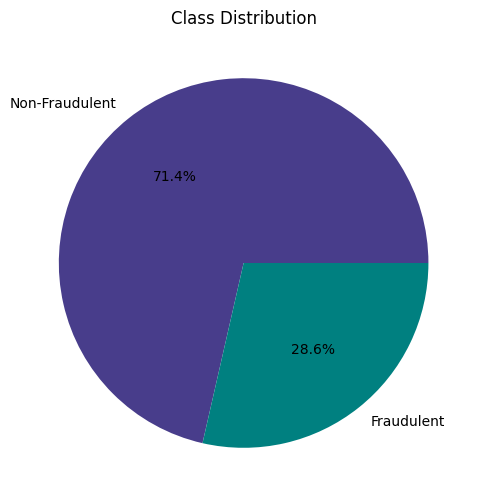

In [55]:
plt.figure(figsize=(8,6))
plt.pie(y_train_res.value_counts(),labels=['Non-Fraudulent','Fraudulent'],autopct='%1.1f%%',colors=['#483D8B','#008080'])
plt.title('Class Distribution')

# T-SNE

In [80]:
X_sample,_=train_test_split(X_train_res,train_size=0.2,random_state=42,stratify=y_train_res)
tsne=TSNE(n_components=1,random_state=42,perplexity=30,max_iter=500,verbose=1)
X_train_tsne=tsne.fit_transform(X_sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 63686 samples in 0.002s...
[t-SNE] Computed neighbors for 63686 samples in 1.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 63686
[t-SNE] Computed conditional probabilities for sample 2000 / 63686
[t-SNE] Computed conditional probabilities for sample 3000 / 63686
[t-SNE] Computed conditional probabilities for sample 4000 / 63686
[t-SNE] Computed conditional probabilities for sample 5000 / 63686
[t-SNE] Computed conditional probabilities for sample 6000 / 63686
[t-SNE] Computed conditional probabilities for sample 7000 / 63686
[t-SNE] Computed conditional probabilities for sample 8000 / 63686
[t-SNE] Computed conditional probabilities for sample 9000 / 63686
[t-SNE] Computed conditional probabilities for sample 10000 / 63686
[t-SNE] Computed conditional probabilities for sample 11000 / 63686
[t-SNE] Computed conditional probabilities for sample 12000 / 63686
[t-SNE] Computed conditional probabilities for sam

In [57]:
'''plt.figure(figsize=(8, 6))
j = np.random.normal(0, 0.05, size=X_train_tsne.shape)
plt.scatter(X_train_tsne.flatten(),j.flatten(), alpha=0.7,color='#483D8B')
plt.title(' 1D t-SNE Visualization')
plt.show()'''

"plt.figure(figsize=(8, 6))\nj = np.random.normal(0, 0.05, size=X_train_tsne.shape)\nplt.scatter(X_train_tsne.flatten(),j.flatten(), alpha=0.7,color='#483D8B')\nplt.title(' 1D t-SNE Visualization')\nplt.show()"

In [60]:
tsne=TSNE(n_components=2,random_state=42,perplexity=30,max_iter=500,verbose=1)
X_train_tsne=tsne.fit_transform(X_sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12737 samples in 0.001s...
[t-SNE] Computed neighbors for 12737 samples in 0.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12737
[t-SNE] Computed conditional probabilities for sample 2000 / 12737
[t-SNE] Computed conditional probabilities for sample 3000 / 12737
[t-SNE] Computed conditional probabilities for sample 4000 / 12737
[t-SNE] Computed conditional probabilities for sample 5000 / 12737
[t-SNE] Computed conditional probabilities for sample 6000 / 12737
[t-SNE] Computed conditional probabilities for sample 7000 / 12737
[t-SNE] Computed conditional probabilities for sample 8000 / 12737
[t-SNE] Computed conditional probabilities for sample 9000 / 12737
[t-SNE] Computed conditional probabilities for sample 10000 / 12737
[t-SNE] Computed conditional probabilities for sample 11000 / 12737
[t-SNE] Computed conditional probabilities for sample 12000 / 12737
[t-SNE] Computed conditional probabilities for sam

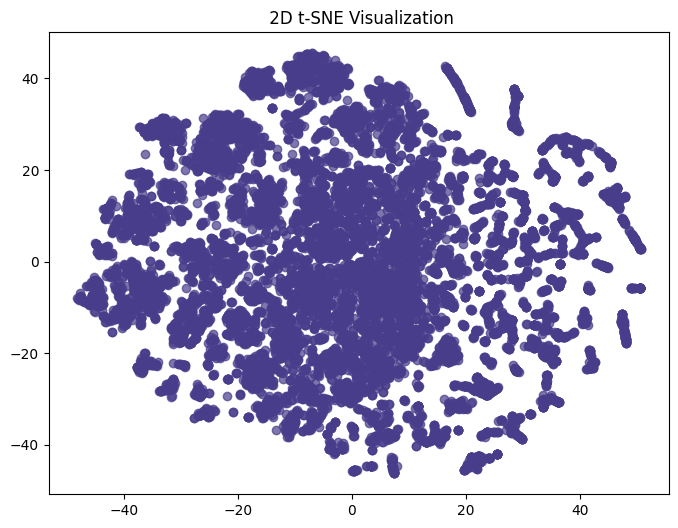

In [61]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], alpha=0.7,color='#483D8B')
plt.title(' 2D t-SNE Visualization')
ax.set_xlabel('TSNE Component 1')
ax.set_ylabel('TSNE Component 2')
plt.show()

This t-SNE plot visualizes the high-dimensional data in two dimensions, where each point represents a data sample, and clusters indicate groups of similar samples in the original feature space

In [62]:
'''tsne=TSNE(n_components=3,random_state=42,perplexity=30,max_iter=500,verbose=1)
X_train_tsne=tsne.fit_transform(X_sample)'''

'tsne=TSNE(n_components=3,random_state=42,perplexity=30,max_iter=500,verbose=1)\nX_train_tsne=tsne.fit_transform(X_sample)'

In [63]:
'''fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], X_train_tsne[:, 2], alpha=0.7,color='#483D8B')
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('TSNE Component 1')
ax.set_ylabel('TSNE Component 2')
ax.set_zlabel('TSNE Component 3')
plt.show()'''

"fig = plt.figure(figsize=(8, 6))\nax = fig.add_subplot(111, projection='3d')\nax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], X_train_tsne[:, 2], alpha=0.7,color='#483D8B')\nax.set_title('3D t-SNE Visualization')\nax.set_xlabel('TSNE Component 1')\nax.set_ylabel('TSNE Component 2')\nax.set_zlabel('TSNE Component 3')\nplt.show()"

This 3D t-SNE plot visualizes high-dimensional data reduced to three components, where each point represents a data sample, and the spatial distribution reflects similarities among samples in the original space

# **DBSCAN**

In [82]:
X_sample,_=train_test_split(X_train_pca,train_size=0.1,random_state=42,stratify=y_train)
dbscan=DBSCAN()
y_pred=dbscan.fit_predict(X_sample)

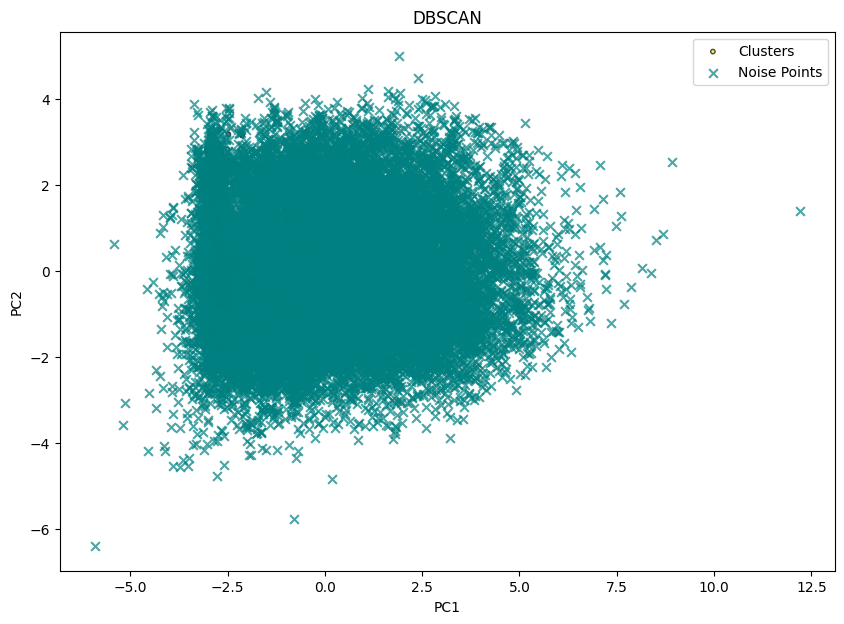

In [65]:
noise_points = X_sample[y_pred == -1]
cluster_points = X_sample[y_pred != -1]

plt.figure(figsize=(10,7))
plt.scatter(cluster_points[:,0],cluster_points[:,1],c=y_pred[y_pred!=-1],s=10,edgecolor='k',alpha=0.7,label='Clusters')
plt.scatter(noise_points[:,0],noise_points[:,1],marker='x',c='#008080',s=40,alpha=0.7,label='Noise Points')
plt.title("DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [66]:
n_noise=list(y_pred).count(-1)
n_clusters= len(set(y_pred))-(1 if -1 in y_pred else 0)

print("Number of clusters found:", n_clusters)
print("Number of noise points: ",n_noise)
print("Percentage of noise points: ", (100 * n_noise / len(y_pred)))

Number of clusters found: 54
Number of noise points:  22198
Percentage of noise points:  97.42801966292134


We applied DBSCAN using the default parameter values, but the result showed that a large portion of the **data points were considered outliers**. This happened because the default parameter settings were not well-suited for our dataset

**Tune eps and min_samples**


eps: The maximum distance between two samples to be considered neighbors(radius).

min_samples: The number of points required to form a dense region (a core point).



In [130]:
scores={}

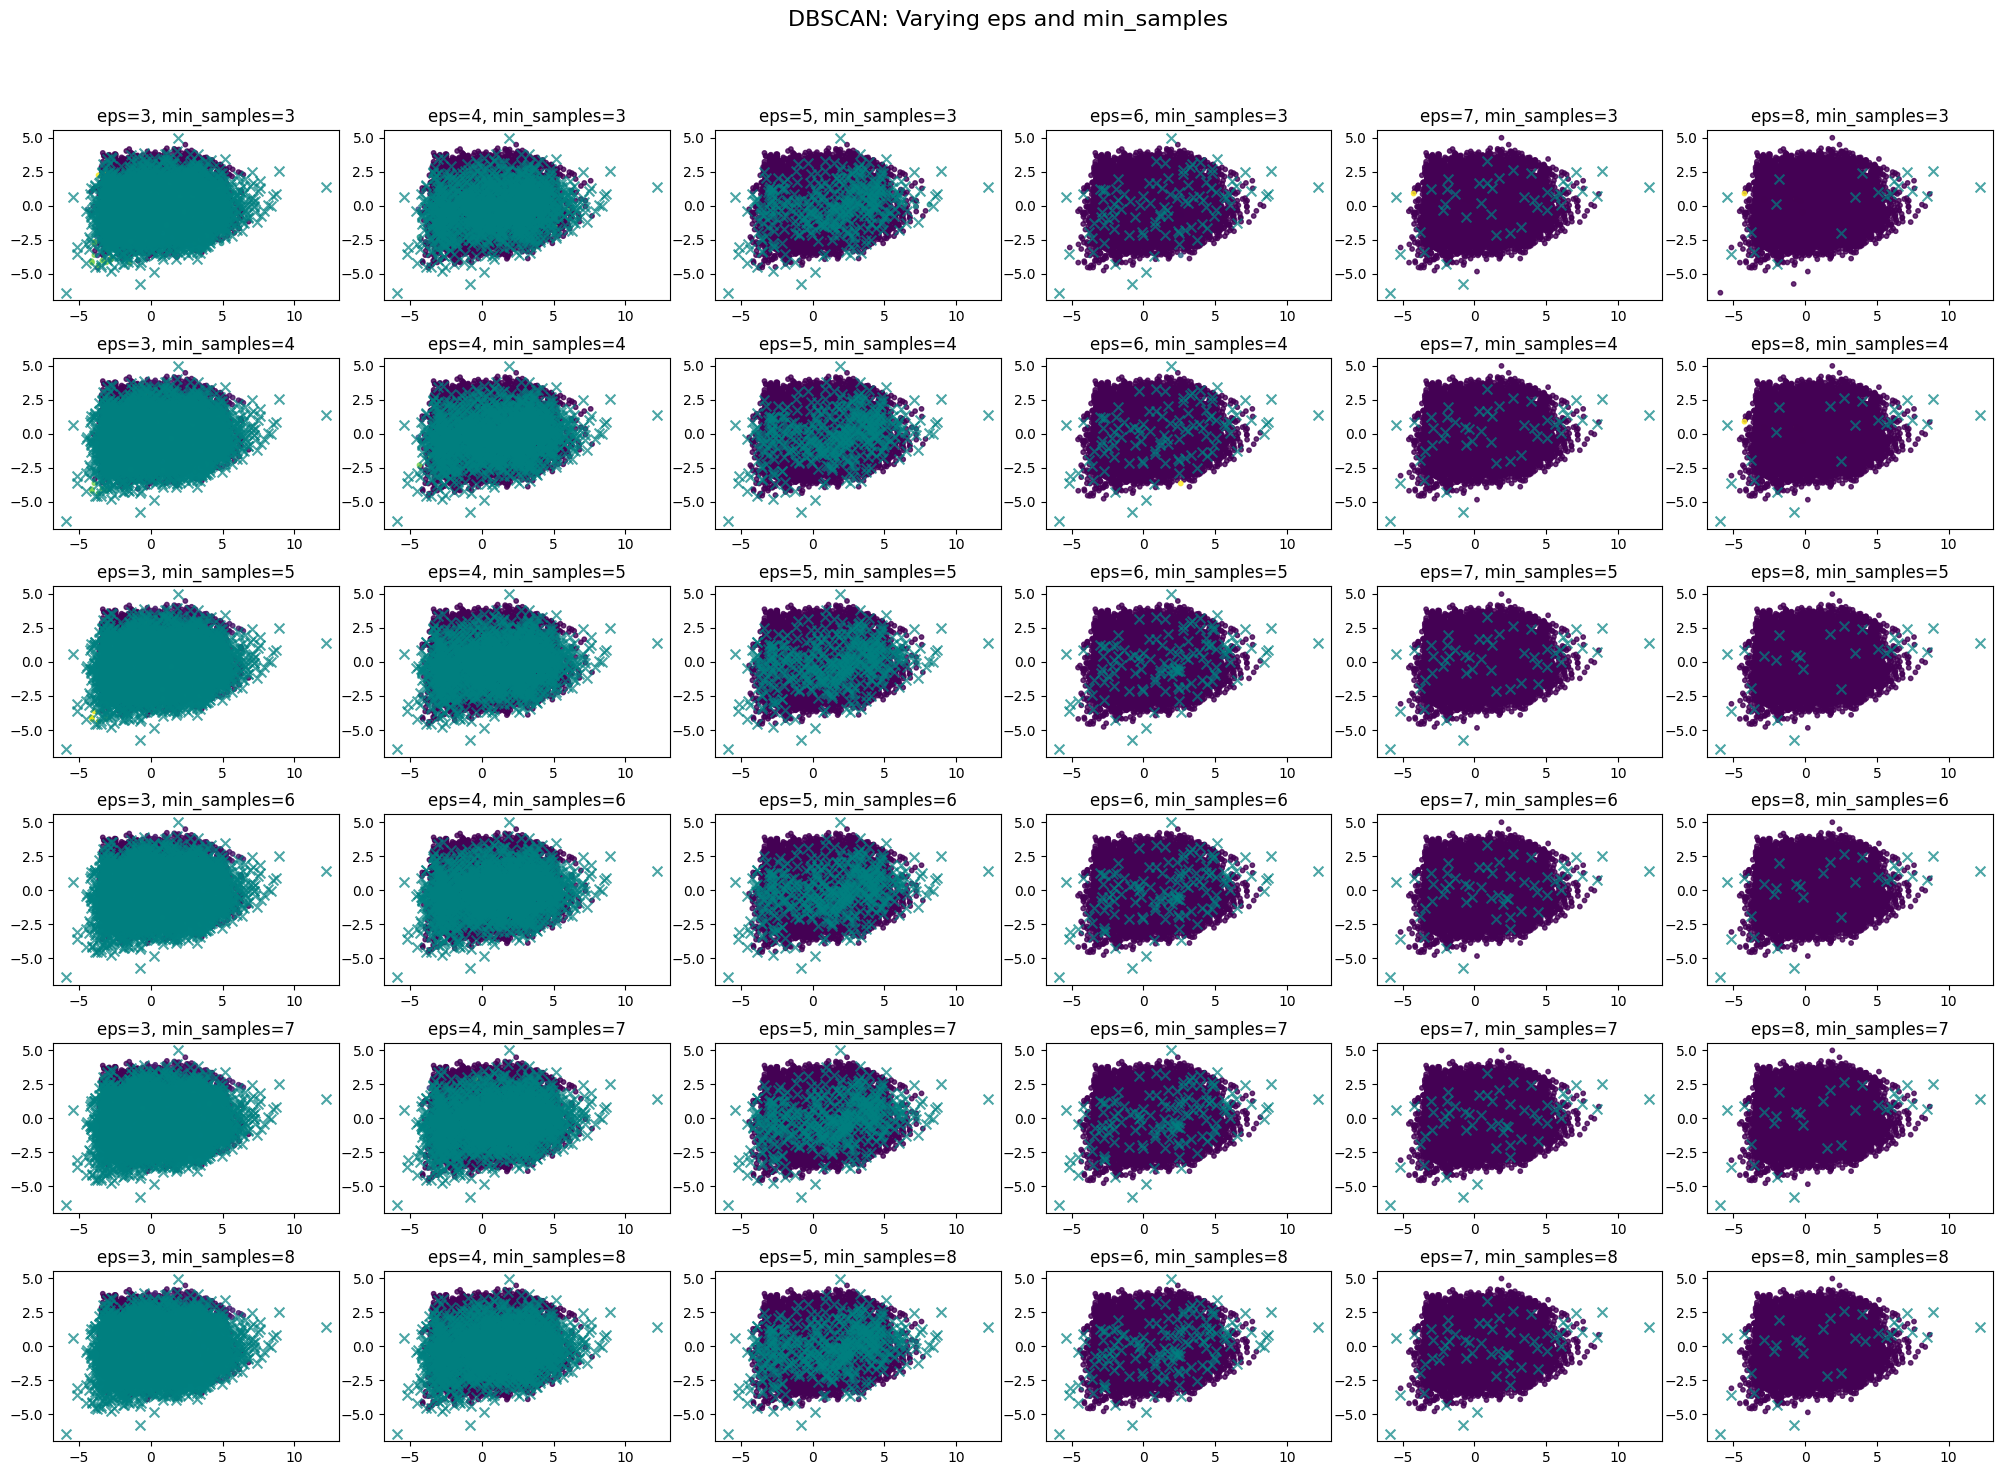

In [131]:
eps_values = [3,4,5,6,7,8]
min_samples_values = [3,4,5,6,7,8]

fig, axs = plt.subplots(len(min_samples_values), len(eps_values), figsize=(20, 15))
fig.suptitle("DBSCAN: Varying eps and min_samples", fontsize=16)

for i, min_samples in enumerate(min_samples_values):
    for j, eps in enumerate(eps_values):
        ax = axs[i, j]
        db = DBSCAN(eps=eps, min_samples=min_samples)
        y = db.fit_predict(X_sample)

        noise = y == -1
        clusters = y != -1
        n_clusters = len(set(y)) - (1 if -1 in y else 0)
        if n_clusters >= 2:
         score= silhouette_score(X_sample,y,sample_size=5000)
         scores[(eps,min_samples)]=score
        else:

         scores[(eps, min_samples)] = -1


        ax.scatter(X_sample[clusters, 0], X_sample[clusters, 1], c=y[clusters], s=10,alpha=0.8)
        ax.scatter(X_sample[noise, 0], X_sample[noise, 1], c='#008080', marker='x', s=50,alpha=0.7)
        ax.set_title(f"eps={eps}, min_samples={min_samples}")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [132]:
best_param=max(scores, key=scores.get)
best_score=scores[best_param]

print(f"Best parameters: eps={best_param[0]}, min_samples={best_param[1]}")
print(f"Best Silhouette Score: {best_score}")

Best parameters: eps=7, min_samples=3
Best Silhouette Score: 0.6386286240694458


In [133]:
print(scores)


{(3, 3): -0.21280796715672745, (4, 3): -0.04283941240144762, (5, 3): 0.15157547706229826, (6, 3): 0.28932100602009425, (7, 3): 0.6386286240694458, (8, 3): 0.4700645773819344, (3, 4): -0.16333493805821692, (4, 4): 0.04095547359292354, (5, 4): 0.3736613426305992, (6, 4): 0.4316375828341752, (7, 4): -1, (8, 4): 0.46435022280762295, (3, 5): -0.14799805389250167, (4, 5): 0.07414150961465414, (5, 5): -1, (6, 5): -1, (7, 5): -1, (8, 5): -1, (3, 6): -0.1502413486798572, (4, 6): 0.10305615169642693, (5, 6): -1, (6, 6): -1, (7, 6): -1, (8, 6): -1, (3, 7): -0.13116783774331592, (4, 7): 0.06292098022488733, (5, 7): -1, (6, 7): -1, (7, 7): -1, (8, 7): -1, (3, 8): -0.12686885741303391, (4, 8): 0.12642153733724598, (5, 8): -1, (6, 8): -1, (7, 8): -1, (8, 8): -1}


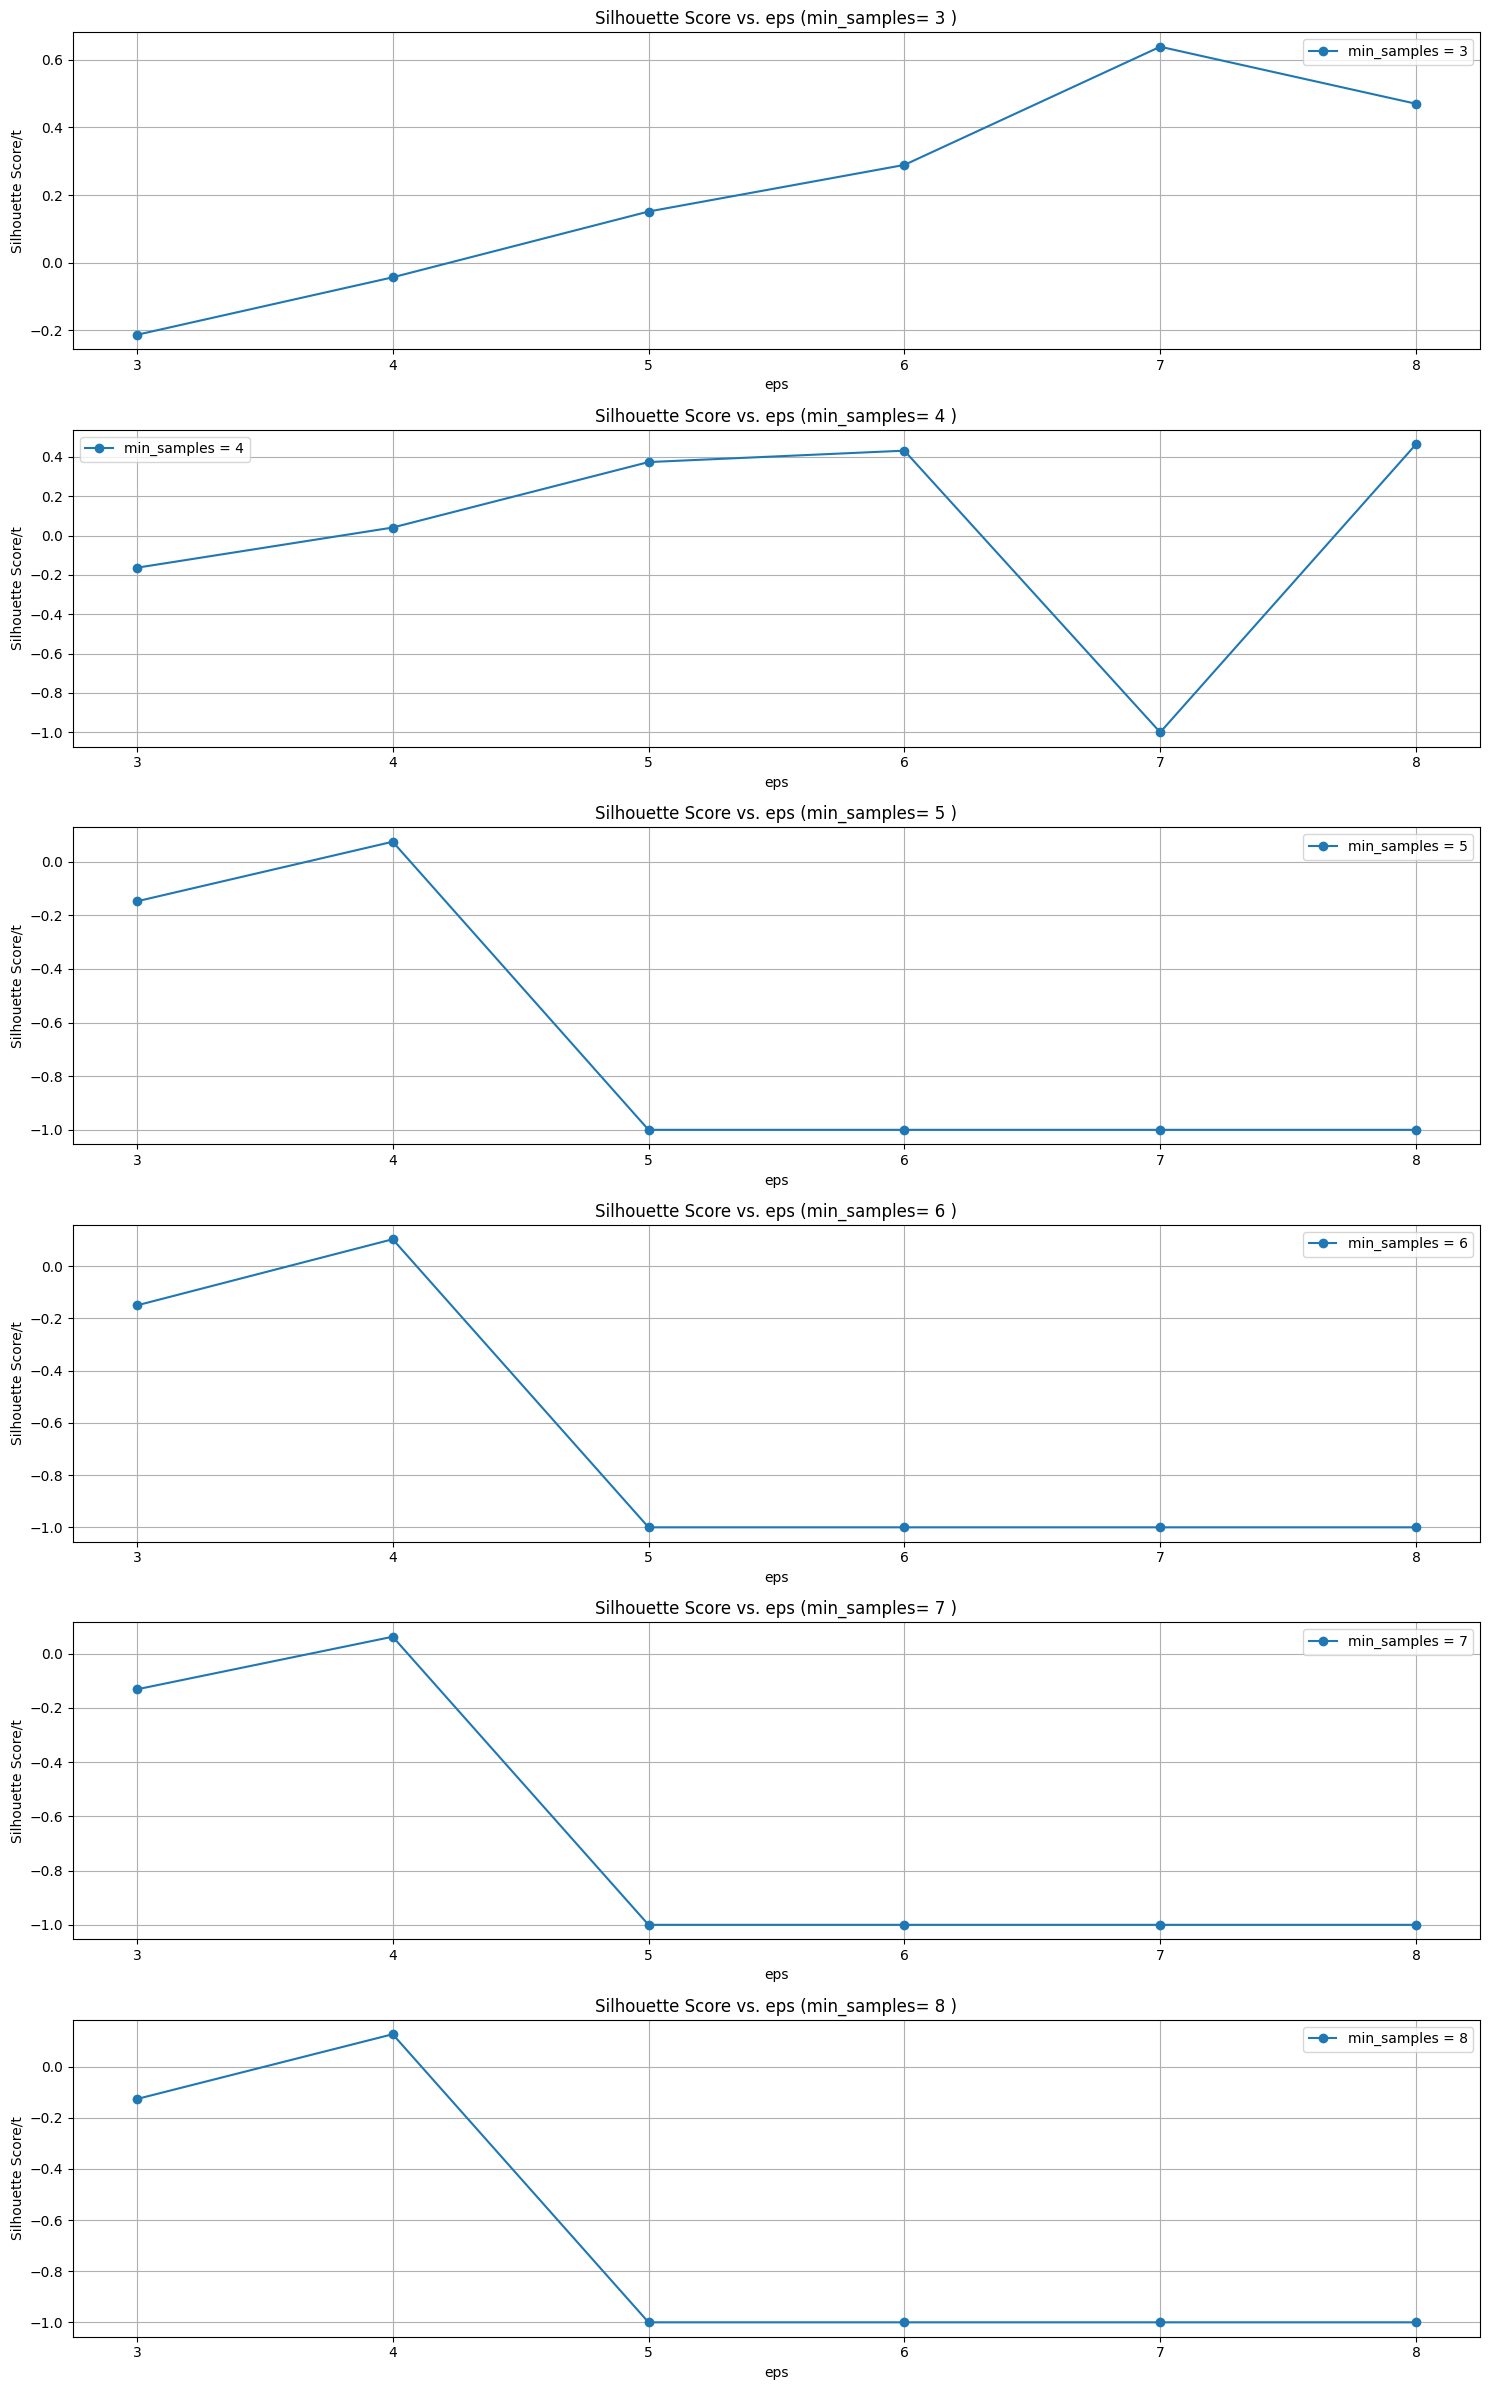

In [148]:
plt.figure(figsize=(15, 4*len(min_samples_values)))
for i, min_samples in enumerate(min_samples_values, 1):
    eps_values = sorted([k[0] for k in scores.keys() if k[1] == min_samples])
    scores_for_min_samples = [scores[(eps, min_samples)] for eps in eps_values]
    plt.subplot(len(min_samples_values), 1, i)
    plt.plot(eps_values, scores_for_min_samples, 'o-', label=f'min_samples = {min_samples}')
    plt.xlabel('eps')
    plt.ylabel('Silhouette Score/t')
    plt.title(f'Silhouette Score vs. eps (min_samples= {min_samples} )')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


In [72]:
'''def silhouette_scorer(estimator, x_scaled_m):
    labels = estimator.fit_predict(x_scaled_m)
    if len(set(labels)) > 1 and -1 not in set(labels):
        return silhouette_score(x_scaled_m, labels,sample_size=5000)
    else:
        return -1

dbcan_grid = {'eps': [7,3,4, 5, 6, 9, 10],
              'min_samples': [5,6,7,8,9,10,11]}
dbcanSearch = GridSearchCV(DBSCAN(), dbcan_grid, scoring=silhouette_scorer)
dbcanSearch.fit(X_sample)

print(dbcanSearch.best_score_)
print(dbcanSearch.best_params_)
dbcan = DBSCAN(eps=7, min_samples=5)
dbcan.fit(X_sample)'''

"def silhouette_scorer(estimator, x_scaled_m):\n    labels = estimator.fit_predict(x_scaled_m)\n    if len(set(labels)) > 1 and -1 not in set(labels):\n        return silhouette_score(x_scaled_m, labels,sample_size=5000)\n    else:\n        return -1\n\ndbcan_grid = {'eps': [7,3,4, 5, 6, 9, 10],\n              'min_samples': [5,6,7,8,9,10,11]}\ndbcanSearch = GridSearchCV(DBSCAN(), dbcan_grid, scoring=silhouette_scorer)\ndbcanSearch.fit(X_sample)\n\nprint(dbcanSearch.best_score_)\nprint(dbcanSearch.best_params_)\ndbcan = DBSCAN(eps=7, min_samples=5)\ndbcan.fit(X_sample)"

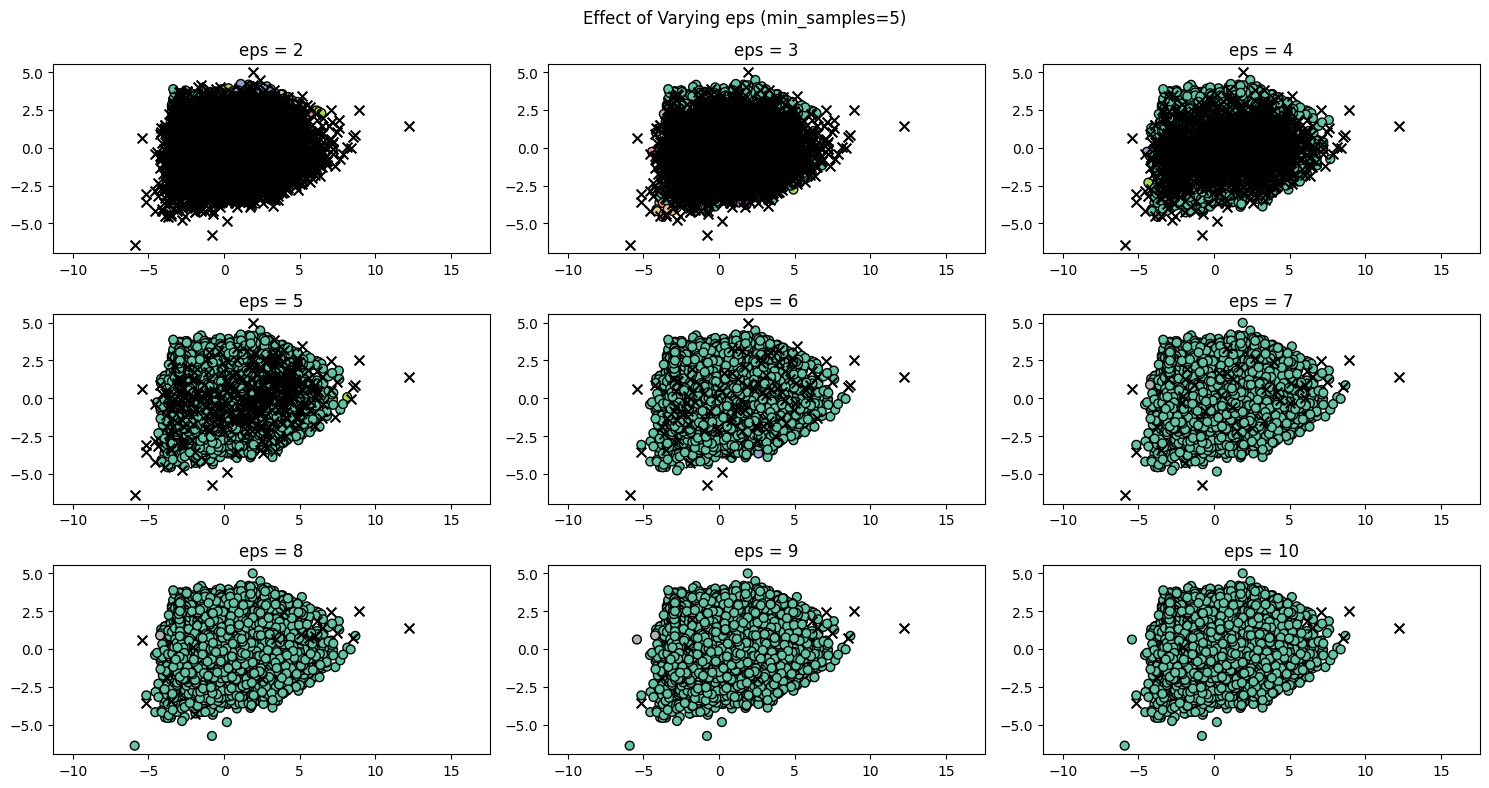

In [73]:
eps_values = [2, 3,4,5,6,7,8,9,10]
plt.figure(figsize=(15, 8))
for i, eps in enumerate(eps_values):
    y = DBSCAN(eps=eps, min_samples=3).fit_predict(X_sample)
    noise = y == -1
    clusters = y != -1

    plt.subplot(3, 3, i+1 )
    plt.scatter(X_sample[clusters, 0], X_sample[clusters, 1], c=y[clusters], cmap='Set2', s=40, edgecolor='k')
    plt.scatter(X_sample[noise, 0], X_sample[noise, 1], c='black', marker='x', s=50)
    plt.title(f"eps = {eps}")
    plt.axis('equal')


plt.suptitle("Effect of Varying eps (min_samples=5)")
plt.tight_layout()
plt.show()

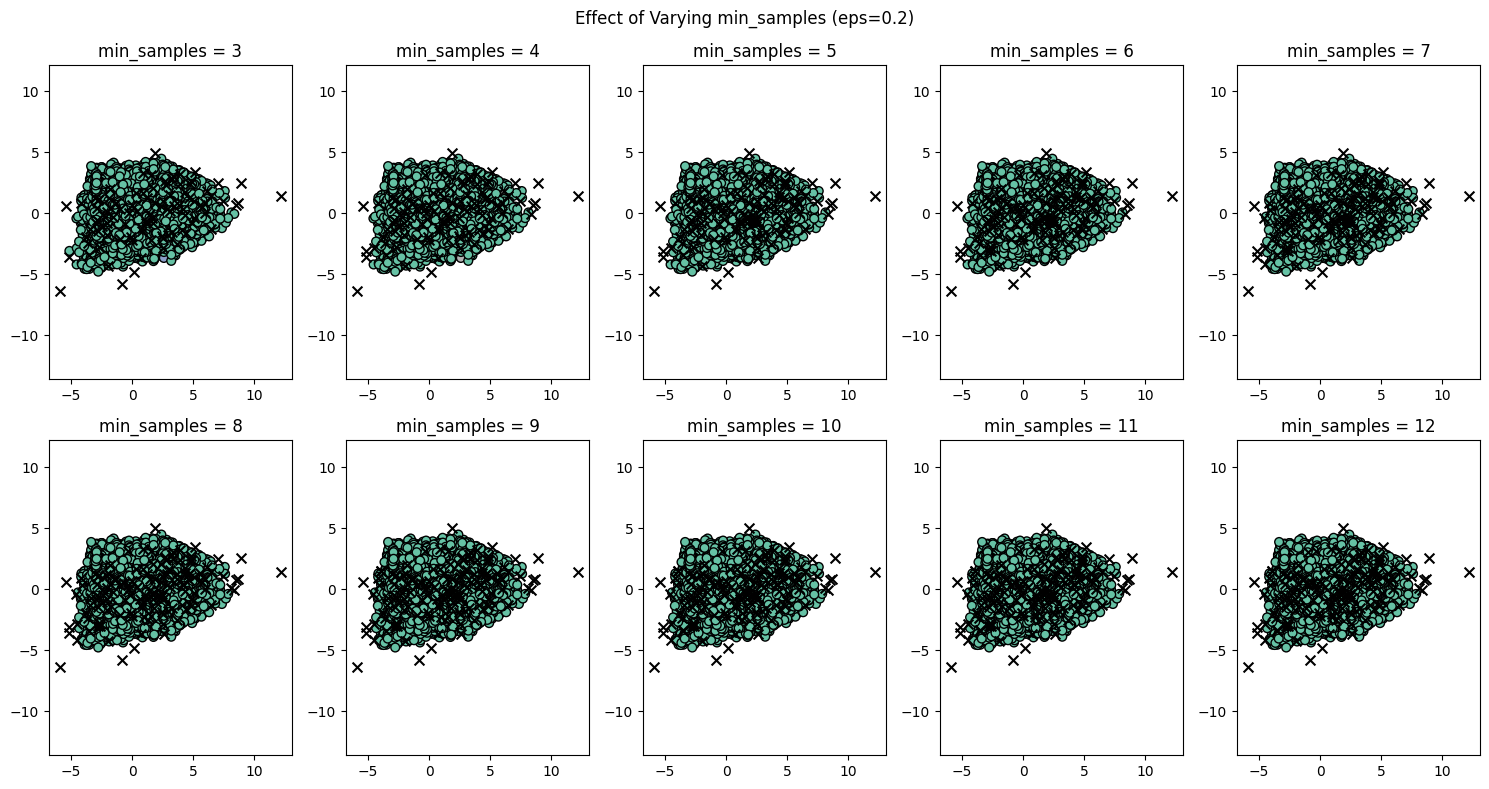

In [74]:
min_samples_values = [3,4, 5,6,7,8,9,10,11,12]
plt.figure(figsize=(15, 8))
for i, ms in enumerate(min_samples_values):
    y = DBSCAN(eps=6, min_samples=ms).fit_predict(X_sample)
    noise = y == -1
    clusters = y != -1

    plt.subplot(2, 5, i + 1)
    plt.scatter(X_sample[clusters, 0], X_sample[clusters, 1], c=y[clusters], cmap='Set2', s=40, edgecolor='k')
    plt.scatter(X_sample[noise, 0], X_sample[noise, 1], c='black', marker='x', s=50)
    plt.title(f"min_samples = {ms}")
    plt.axis('equal')

plt.suptitle("Effect of Varying min_samples (eps=0.2)")
plt.tight_layout()
plt.show()

We performed a manual grid search by testing a range of values for eps and min_samples. At first, we used a wide range to cover all possible cases, but due to DBSCAN’s poor performance on large datasets, we later narrowed it down to a smaller set of values.

In DBSCAN, noise points are those that do not belong to any cluster — they're considered outliers or anomalies

In [75]:
dbscan=DBSCAN(eps=6, min_samples=7)
labels=dbscan.fit_predict(X_sample)

n_noise=list(labels).count(-1)
n_clusters= len(set(labels))-(1 if -1 in labels else 0)

print("Number of clusters found:", n_clusters)
print("Number of noise points: ",n_noise)
print("Percentage of noise points: ", (100 * n_noise / len(labels)))

Number of clusters found: 1
Number of noise points:  138
Percentage of noise points:  0.605688202247191


After tuning the DBSCAN parameters, the algorithm successfully identified one cluster along with several noise points. This result aligns with the nature of the dataset, which is expected to contain a single dense group (normal transactions) and scattered outliers (fraud cases).

**DBSCAN detected X noise points — and this shows its strength in separating structure from randomness.**

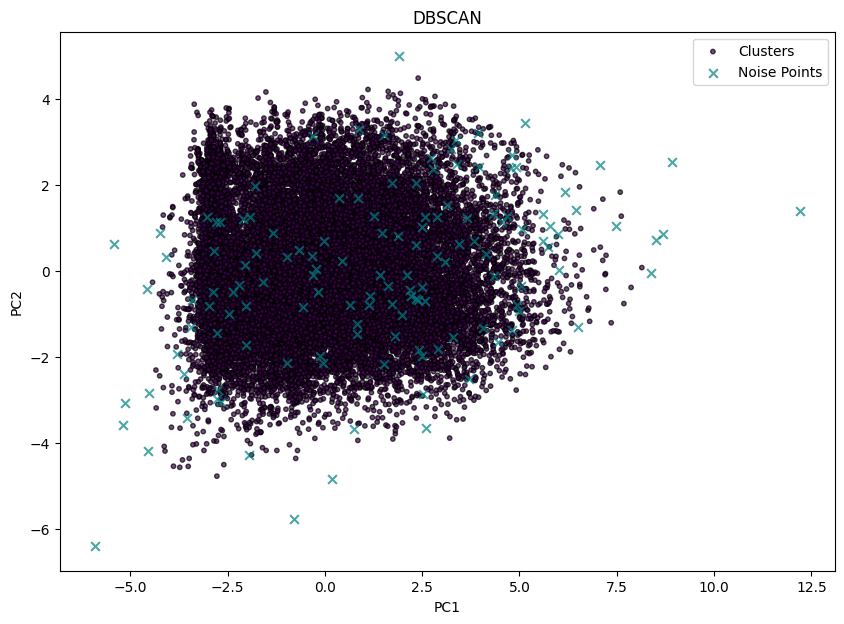

In [76]:
noise_points=X_sample[labels == -1]
cluster_points= X_sample[labels != -1]
plt.figure(figsize=(10,7))
plt.scatter(cluster_points[:,0],cluster_points[:,1],c=labels[labels!=-1],s=10,edgecolor='k',alpha=0.7,label='Clusters')
plt.scatter(noise_points[:,0],noise_points[:,1],c='#008080',s=40,alpha=0.7,marker='x',label='Noise Points')
plt.title("DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [103]:
if len(set(labels) - {-1}) > 1:
    score_dbscan_ch= calinski_harabasz_score(X_sample, labels)
else:
    score_dbscan_ch= -1

print("Calinski-Harabasz Score - DBSCAN:", score_dbscan_ch)

Calinski-Harabasz Score - DBSCAN: -1


DBSCAN formed only one cluster or all points were labeled as noise. Calinski-Harabasz score is not defined in this case

In [78]:
Ndf=pd.DataFrame(noise_points)
print("Noise stats:\n", Ndf.describe())

Noise stats:
                0           1           2           3           4           5   \
count  138.000000  138.000000  138.000000  138.000000  138.000000  138.000000   
mean     1.406780   -0.072592    0.197803   -0.419055   -0.481132    0.079977   
std      3.525984    1.964970    1.815952    1.926990    1.602087    1.667557   
min     -5.904786   -6.398541   -5.096337   -5.909486   -6.374173   -5.218017   
25%     -1.725754   -1.281434   -0.900133   -1.522597   -1.582418   -0.815163   
50%      1.775787    0.093640    0.213161   -0.576379   -0.440844    0.077221   
75%      3.909568    1.241411    1.333376    0.610346    0.451982    1.165497   
max     12.196603    4.987972    4.562641    5.843766    2.833078    6.043865   

               6           7           8           9   ...          14  \
count  138.000000  138.000000  138.000000  138.000000  ...  138.000000   
mean     0.190354    0.099495    0.736554    1.073794  ...   -0.452810   
std      1.963951    1.685019    2

DBSCAN identified 312 noise points, representing 1.24% of the data. Based on feature distribution analysis, these points showed significantly different behavior compared to clustered data. This suggests that DBSCAN was effective in identifying potential fraudulent or anomalous transactions

**Number of Clusters:**


* The plot shows 2 main clusters (each represented by a distinct color).

* The clusters are densely packed in the center, indicating high-density regions.

**Noise Points:**

* The black 'X' markers represent noise points (outliers).

These points were classified as noise because:

They have fewer than min_samples neighbors within the eps radius.

They are likely located at the edges or far from the main clusters.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 22784 samples in 0.001s...
[t-SNE] Computed neighbors for 22784 samples in 0.674s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22784
[t-SNE] Computed conditional probabilities for sample 2000 / 22784
[t-SNE] Computed conditional probabilities for sample 3000 / 22784
[t-SNE] Computed conditional probabilities for sample 4000 / 22784
[t-SNE] Computed conditional probabilities for sample 5000 / 22784
[t-SNE] Computed conditional probabilities for sample 6000 / 22784
[t-SNE] Computed conditional probabilities for sample 7000 / 22784
[t-SNE] Computed conditional probabilities for sample 8000 / 22784
[t-SNE] Computed conditional probabilities for sample 9000 / 22784
[t-SNE] Computed conditional probabilities for sample 10000 / 22784
[t-SNE] Computed conditional probabilities for sample 11000 / 22784
[t-SNE] Computed conditional probabilities for sample 12000 / 22784
[t-SNE] Computed conditional probabilities for sam

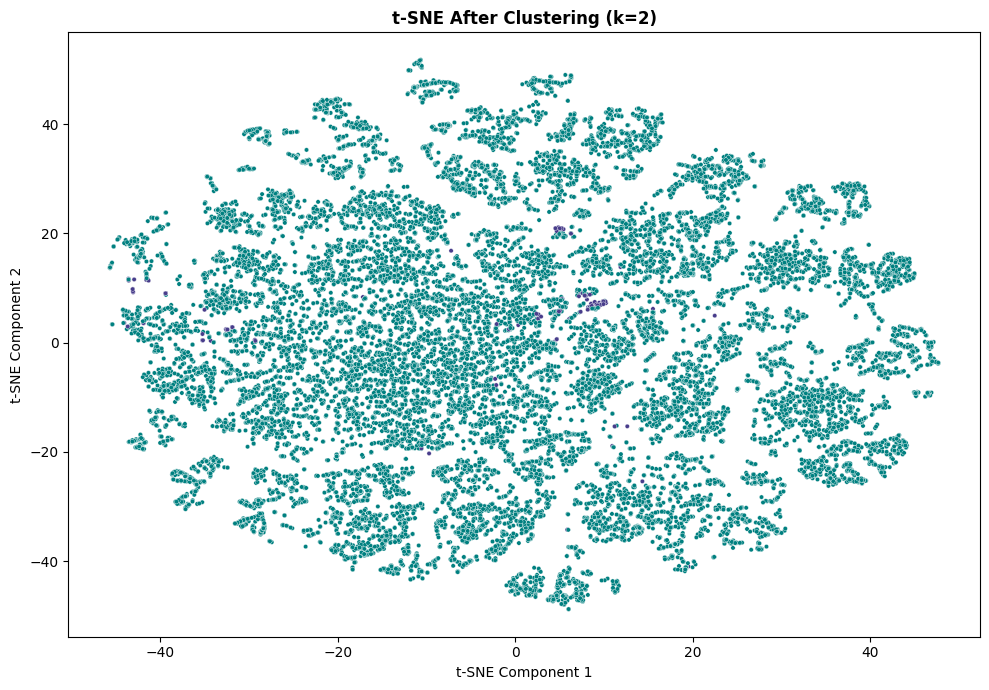

In [83]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=500, verbose=1)
X_train_tsne = tsne.fit_transform(X_sample)
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=labels, palette=['#483D8B','#008080'], s=10, legend=None)
plt.title(f"t-SNE After Clustering (k={2})",  fontweight="bold")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()

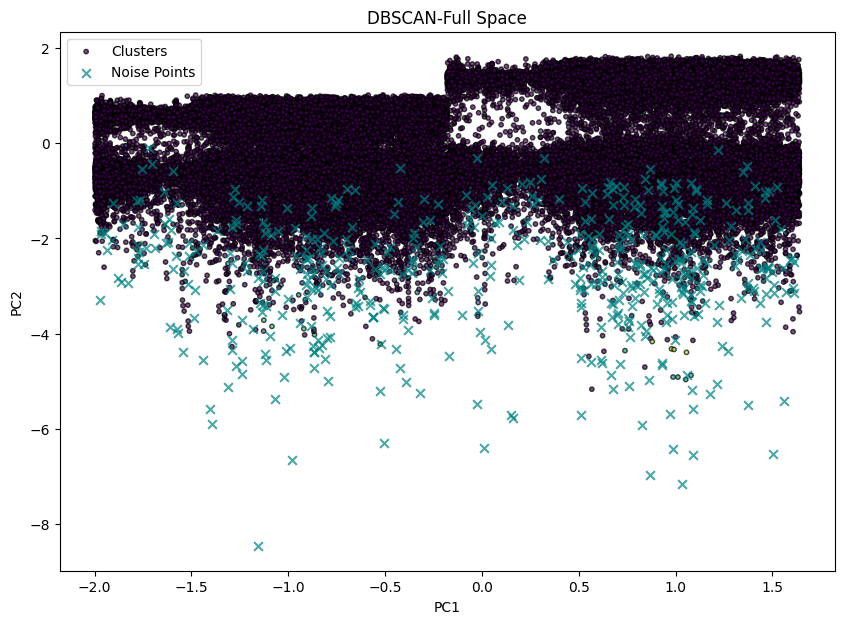

In [84]:
X_sample_full,_=train_test_split(X_train_scaled,train_size=.4,stratify=y_train)
db=DBSCAN(eps=6, min_samples=5)
y_pred=db.fit_predict(X_sample_full)
noise_points=X_sample_full[y_pred == -1]
cluster_points= X_sample_full[y_pred != -1]
plt.figure(figsize=(10,7))
plt.scatter(cluster_points[:,0],cluster_points[:,1],c=y_pred[y_pred!=-1],s=10,edgecolor='k',alpha=0.7,label='Clusters')
plt.scatter(noise_points[:,0],noise_points[:,1],c='#008080',s=40,alpha=0.7,marker='x',label='Noise Points')
plt.title("DBSCAN-Full Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

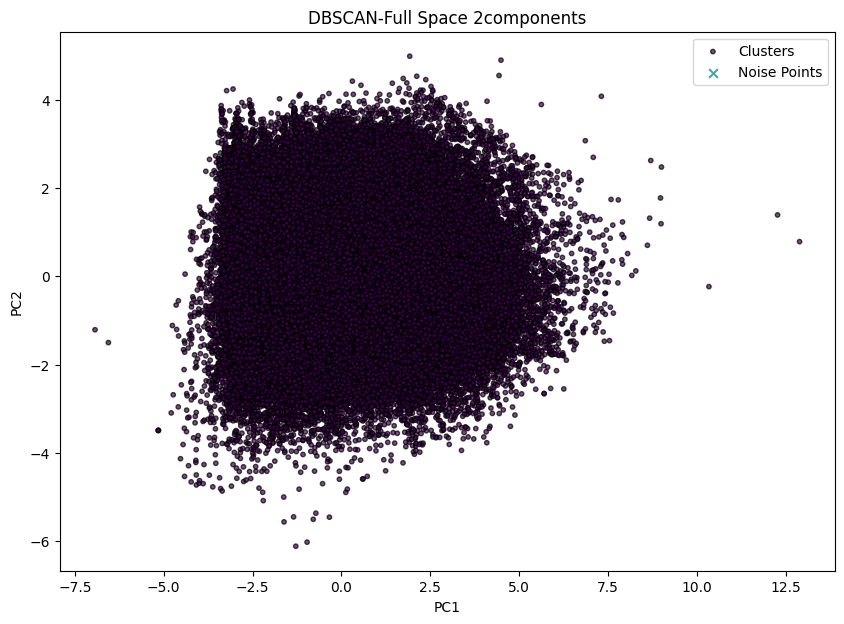

In [85]:
pca2d=PCA(n_components=2)
X_sample_full_pca=pca2d.fit_transform(X_sample_full)

db=DBSCAN(eps=6, min_samples=5)
y_pred=db.fit_predict(X_sample_full_pca)
noise_points=X_sample_full_pca[y_pred == -1]
cluster_points= X_sample_full_pca[y_pred != -1]
plt.figure(figsize=(10,7))
plt.scatter(cluster_points[:,0],cluster_points[:,1],c=y_pred[y_pred!=-1],s=10,edgecolor='k',alpha=0.7,label='Clusters')
plt.scatter(noise_points[:,0],noise_points[:,1],c='#008080',s=40,alpha=0.7,marker='x',label='Noise Points')
plt.title("DBSCAN-Full Space 2components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

Plot clusters and compare to K-Means clusters

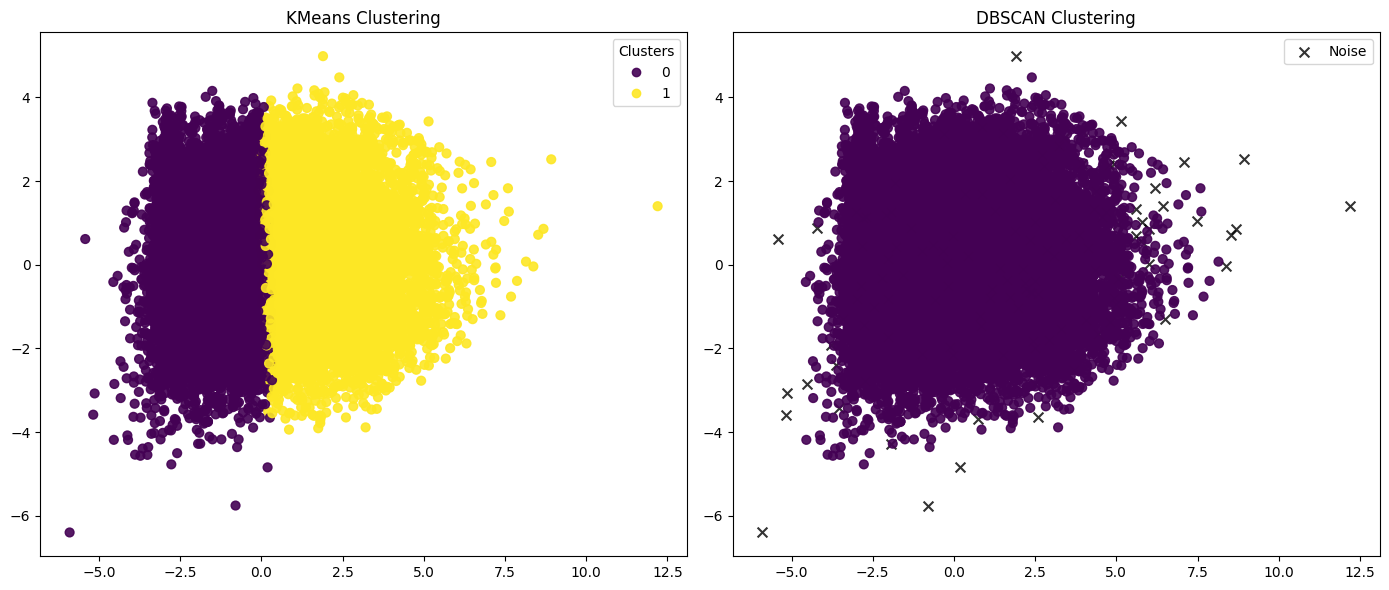

In [98]:
kmeans = KMeans(n_clusters=2, random_state=0)
y_kmeans = kmeans.fit_predict(X_sample)

dbscan = DBSCAN(eps=6, min_samples=5)
y_dbscan = dbscan.fit_predict(X_sample)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
scatter_kmeans = axs[0].scatter(X_sample[:, 0], X_sample[:, 1], c=y_kmeans, cmap=plt.cm.viridis, s=40, alpha=0.9)
axs[0].set_title("KMeans Clustering")
axs[0].legend(*scatter_kmeans.legend_elements(), title="Clusters")

noise_points = X_sample[y_dbscan == -1]
axs[1].scatter(noise_points[:, 0], noise_points[:, 1], color='black', marker='x', s=50, label="Noise", alpha=0.8)

valid_points = X_sample[y_dbscan != -1]
valid_labels = y_dbscan[y_dbscan != -1]
scatter_dbscan = axs[1].scatter(valid_points[:, 0], valid_points[:, 1], c=valid_labels, cmap=plt.cm.viridis, s=40, alpha=0.9)

axs[1].set_title("DBSCAN Clustering")
axs[1].legend()
plt.tight_layout()
plt.show()


In [109]:
evaluations = {'KMeans': {'Silhouette Score': silhouette_score(X_sample, y_kmeans), 'Davies-Bouldin Index': davies_bouldin_score(X_sample, y_kmeans), 'Calinski-Harabasz Score':calinski_harabasz_score(X_sample, y_kmeans)}}


if len(set(y_dbscan) - {-1}) > 1:
    evaluations['DBSCAN'] ={
        'Silhouette Score': silhouette_score(X_sample[y_dbscan != -1], y_dbscan[y_dbscan != -1]),
        'Davies-Bouldin Index': davies_bouldin_score(X_sample[y_dbscan != -1], y_dbscan[y_dbscan != -1]),
        'Calinski-Harabasz Score': calinski_harabasz_score(X_sample[y_dbscan != -1], y_dbscan[y_dbscan != -1])
    }
else:
    evaluations['DBSCAN'] = {'Silhouette Score': -1, 'Davies-Bouldin Index': -1, 'Calinski-Harabasz Score': -1}

In [111]:
evaluations=pd.DataFrame(evaluations)
evaluations

KMeans  DBSCAN
Silhouette Score            0.106616      -1
Davies-Bouldin Index        2.795696      -1
Calinski-Harabasz Score  2687.527862      -1

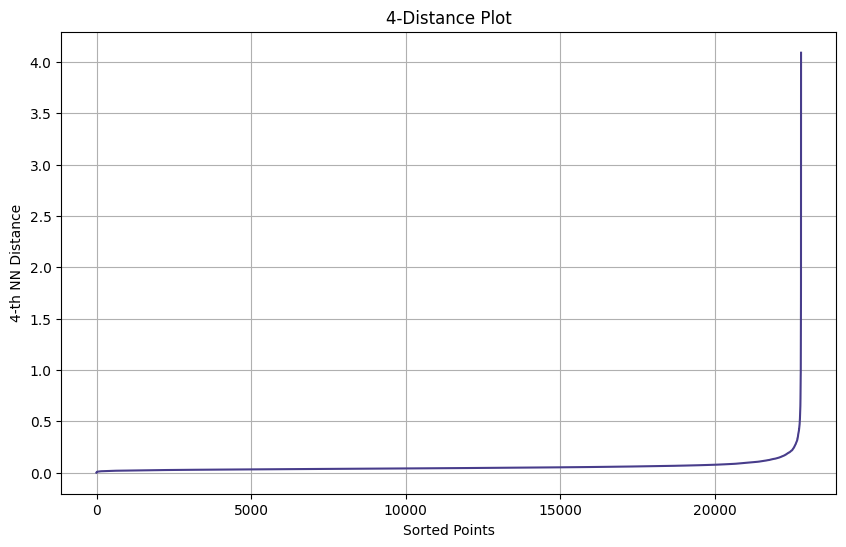

In [120]:
X = X_sample[:,:2]
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
k_distances = np.sort(distances[:, 4])
plt.figure(figsize=(10,6))
plt.plot(k_distances,color='#483D8B')
plt.xlabel("Sorted Points")
plt.ylabel("4-th NN Distance")
plt.title("4-Distance Plot")
plt.grid(True)
plt.show()

The first ~20,000 points have very small distances (close to 0), indicating a densely packed region.
These points are likely part of the core clusters, where each point is very close to its 4th nearest neighbor.

Around 20,000 points, there is a sudden upward curve, indicating a "knee" or "elbow" point